## ResNet18 - MNIST

In [3]:
import sys
sys.path.append('../models')
sys.path.append('.../MLResearch')
from resnet import *



In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from resnet import ResNet18
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [182]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [5]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create the data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


nclass = 10 # number of classes
scale = 64 # scale factor for num channels
channels = 1 # number of input channels

model = ResNet18(nclass, scale, channels, proto_layer=4,layer_norm = False, entry_stride = 1).to(device)

# Define the loss function
cost = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 10

64


- Train on MNist,
- Evaluate on FSHN, accuracy + fv_analysis,
- Line graph (one graph 10 lines (MNIST, 100 lines(CIFAR))),
- group by class, Vice-Versa

In [6]:
def cos_sim(model, train_loader, dataset_name, num_epochs):
    
    model.eval()
    model.load_state_dict(torch.load(f'model_{dataset_name}_epoch_{num_epochs+1}.pth'))
    model.to(device)

    class_similarities = {}

    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            feat_vec, _ = model(inputs)  ## get feature vectors from the model

            for i in range(len(feat_vec)):
                for j in range(i+1, len(feat_vec)):

                    sim = F.cosine_similarity(feat_vec[i].unsqueeze(0), feat_vec[j].unsqueeze(0)) ## calculate cosine similarity between feature vectors

                    if labels[i] == labels[j]:   #within class
                        class_id = labels[i].item()

                        if class_id not in class_similarities:
                            class_similarities[class_id] = {'intra_sim': [], 'inter_sim': []}

                        class_similarities[class_id]['intra_sim'].append(sim.item())
                    else:                           #between class
                        class_id_i, class_id_j = labels[i].item(), labels[j].item()

                        if class_id_i not in class_similarities:
                            class_similarities[class_id_i] = {'intra_sim': [], 'inter_sim': []}

                        if class_id_j not in class_similarities:
                            class_similarities[class_id_j] = {'intra_sim': [], 'inter_sim': []}
                            
                        

                        class_similarities[class_id_i]['inter_sim'].append(sim.item())
                        class_similarities[class_id_j]['inter_sim'].append(sim.item())

    return class_similarities
    

Note torch.nn.functional.cosine_similarity is defined as:
 $$
\text{CosSim} = \frac{\vec{x}_1 \cdot \vec{x}_2}{\max(\|\vec{x}_1\|_2, \epsilon) \cdot \max(\|\vec{x}_2\|_2, \epsilon)}
 $$
 where $\epsilon$ is 1e-8 to avoid division by 0 and the magnitude is defined as $L_2$ norm

In [7]:
def train(model, train_loader, optimizer, dataset_name, num_epochs):
    
    total_step = len(train_loader)
   
    for epoch in range(num_epochs):

        for i, (images, labels) in enumerate(train_loader):

            images = images.to(device)
            labels = labels.to(device)

            ## forward pass ##
            outputs = model(images)
            loss = cost(outputs, labels)

            ## backwards pass and optimizer step (learning) ##
            optimizer.zero_grad()  # zeroes out the gradients, removing exisitng ones to avoid accumulation
            loss.backward()  # gradient of loss, how much each parameter contributed to the loss
            optimizer.step()  # adjusts parameters based on results to minimize loss

            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        
    torch.save(model.state_dict(), f'model_{dataset_name}_epoch_{num_epochs+1}.pth') #save after training        

 Train model

In [186]:
#train(model, train_loader, optimizer, 'mnist', num_epochs)

Compute cos_sim()

In [187]:
cos_sim_matrix = cos_sim(model, train_loader, 'mnist', num_epochs)
#cos_sim_matrix_np = np.array(cos_sim_matrix)


In [8]:
def print_res(cos_sim_matrix_np):
    for class_id in cos_sim_matrix_np:
        print(f"Class {class_id}:\nIntra-class Similarity: Mean = {np.mean(cos_sim_matrix_np[class_id]['intra_sim'])}, Std = {np.std(cos_sim_matrix_np[class_id]['intra_sim'])}, Var = {np.var(cos_sim_matrix_np[class_id]['intra_sim'])}\nInter-class similarity: Mean = {np.mean(cos_sim_matrix_np[class_id]['inter_sim'])}, Std = {np.std(cos_sim_matrix_np[class_id]['inter_sim'])}, Var = {np.var(cos_sim_matrix_np[class_id]['inter_sim'])}\n")


In [189]:
print_res(cos_sim_matrix)

Class 3:
Intra-class Similarity: Mean = 0.9555175130204624, Std = 0.02161100167979846, Var = 0.00046703539360425176
Inter-class similarity: Mean = 0.5058199888807111, Std = 0.0788395966791004, Var = 0.006215682004523218

Class 8:
Intra-class Similarity: Mean = 0.9468827188759422, Std = 0.027028057415849387, Var = 0.0007305158876744511
Inter-class similarity: Mean = 0.5200085829410575, Std = 0.08250354657128407, Var = 0.00680683519684004

Class 1:
Intra-class Similarity: Mean = 0.9706808025151394, Std = 0.019119307487005917, Var = 0.00036554791878268045
Inter-class similarity: Mean = 0.483639554773013, Std = 0.07174780665233409, Var = 0.005147747759420715

Class 5:
Intra-class Similarity: Mean = 0.9489564250115163, Std = 0.023591986731844636, Var = 0.0005565818379555334
Inter-class similarity: Mean = 0.532882480222801, Std = 0.07229456228561844, Var = 0.005226503736069164

Class 9:
Intra-class Similarity: Mean = 0.9563778484689778, Std = 0.022434565854789205, Var = 0.0005033097450928738

 Plot results

In [9]:
def plot_line_graph(cos_sim_matrix_np,sample_size=100):
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))
    fig.suptitle("Cosine Similarity Line Graph")

    for class_id in cos_sim_matrix_np:
        
        intra_similarities = np.random.choice(cos_sim_matrix_np[class_id]['intra_sim'], size=sample_size, replace=False)
        inter_similarities = np.random.choice(cos_sim_matrix_np[class_id]['inter_sim'], size=sample_size, replace=False)

        axs[0].plot(range(len(intra_similarities)), intra_similarities, label=f'class {class_id}')
        axs[1].plot(range(len(inter_similarities)), inter_similarities, label=f'class {class_id}')

    axs[0].set_title("Intra-class Similarity")
    axs[0].set_xlabel("Sample pair")
    axs[0].set_ylabel("Cosine similarity")

    axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    axs[1].set_title("Inter-class Similarity")
    axs[1].set_xlabel("Sample pair")
    axs[1].set_ylabel("Cosine similarity")
    
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()


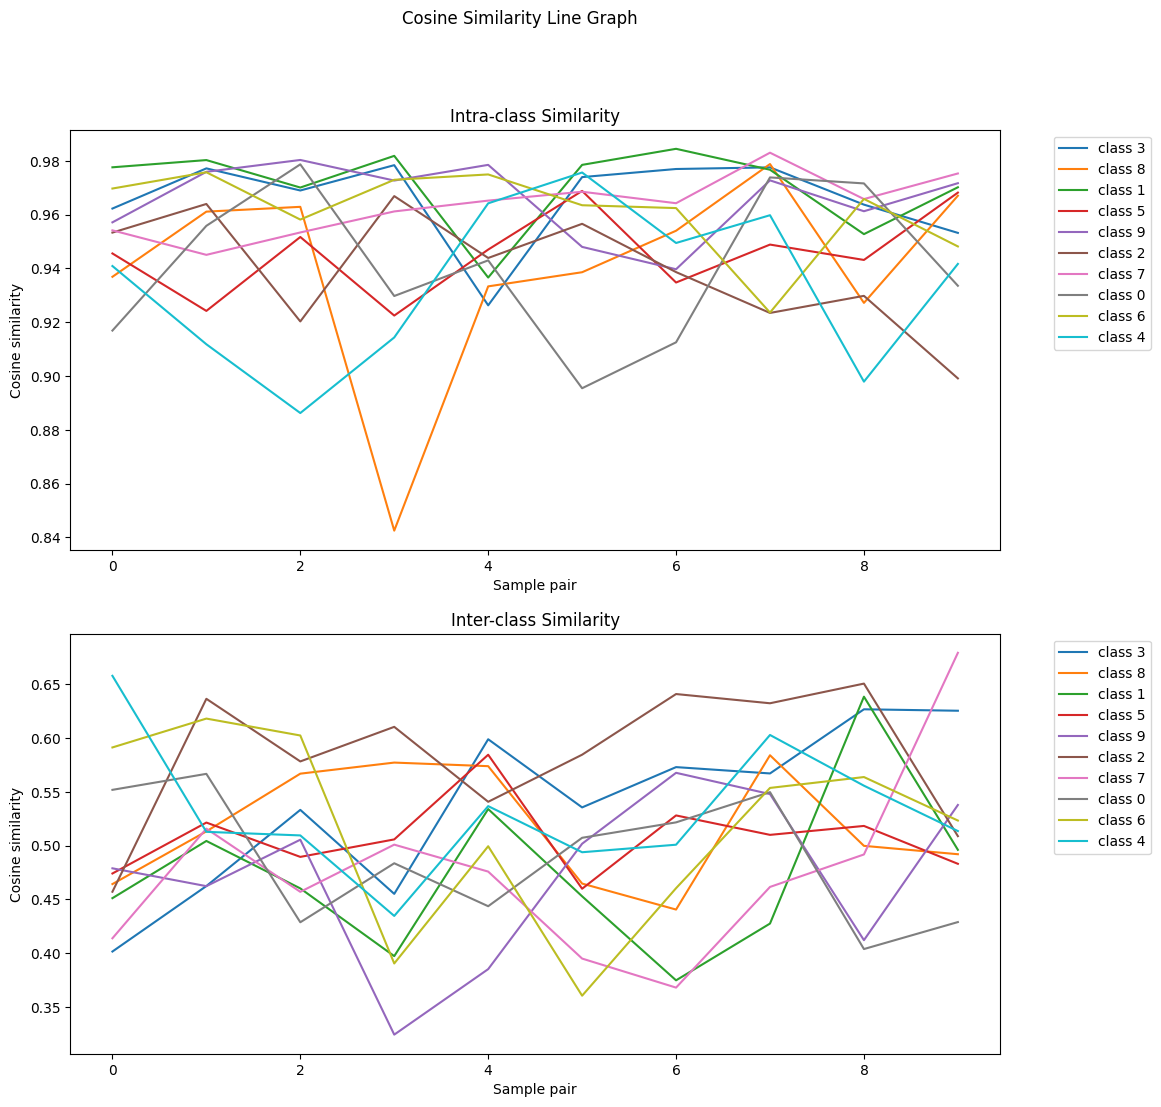

In [191]:
plot_line_graph(cos_sim_matrix,10)

In [10]:
def plot_hist(cos_sim_matrix_np):

    for class_id in cos_sim_matrix_np:
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle(f"Cosine Similarity for Class: {class_id}")

        # Intra-class similarity
        axs[0].hist(cos_sim_matrix_np[class_id]['intra_sim'], bins=50, color='blue', edgecolor='black', alpha=0.5)
        axs[0].set_title(f"Intra-class similarity")
        axs[0].set_xlabel("cosine similarity")
        axs[0].set_ylabel("Frequency")

        # Inter-class similarity
        axs[1].hist(cos_sim_matrix_np[class_id]['inter_sim'], bins=50, color='red', edgecolor='black', alpha=0.5)
        axs[1].set_title(f"Inter-class similarity")
        axs[1].set_xlabel("cosine similarity")
        axs[1].set_ylabel("Frequency")

        # Show the figure for each class_id
        plt.show()

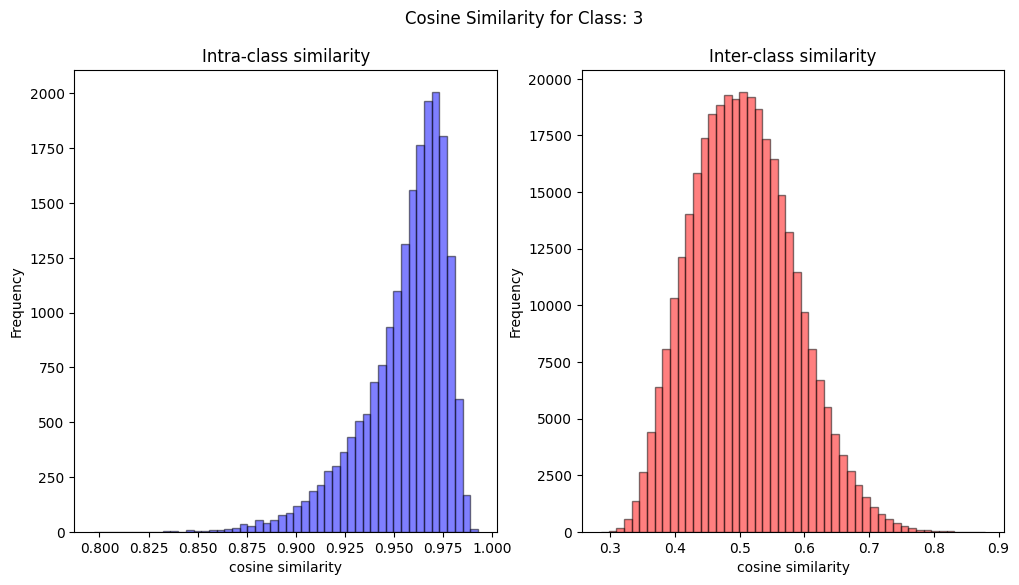

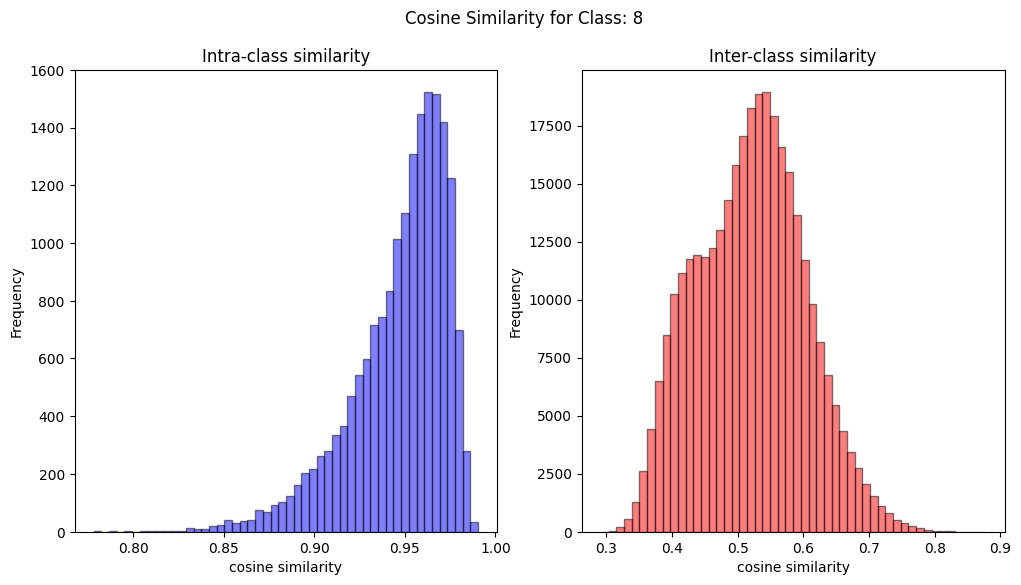

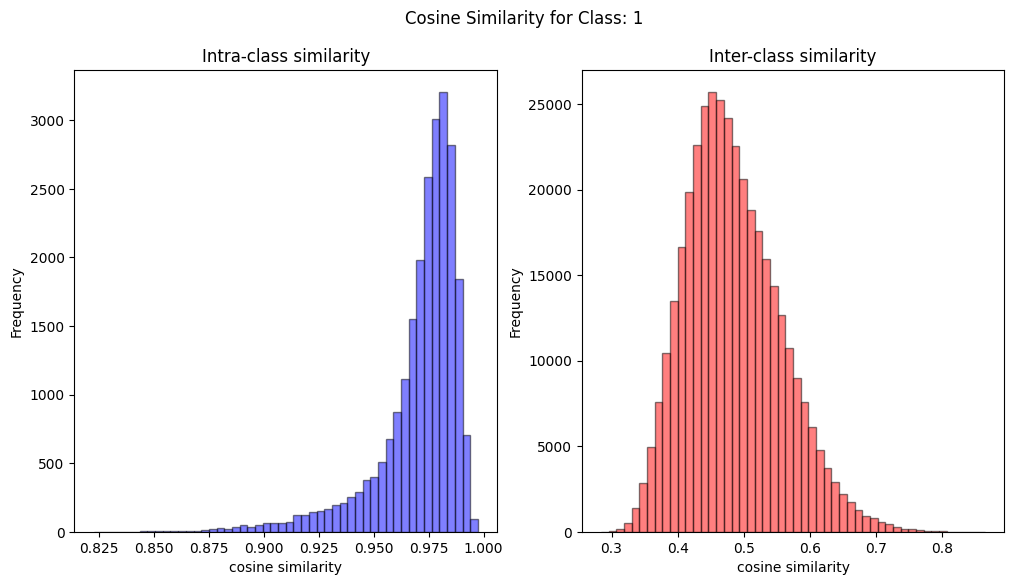

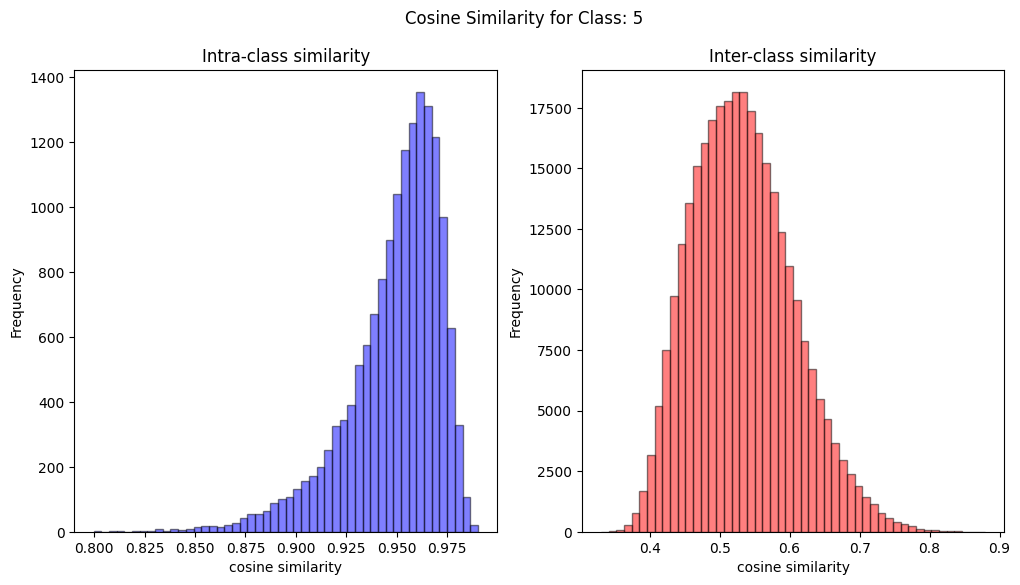

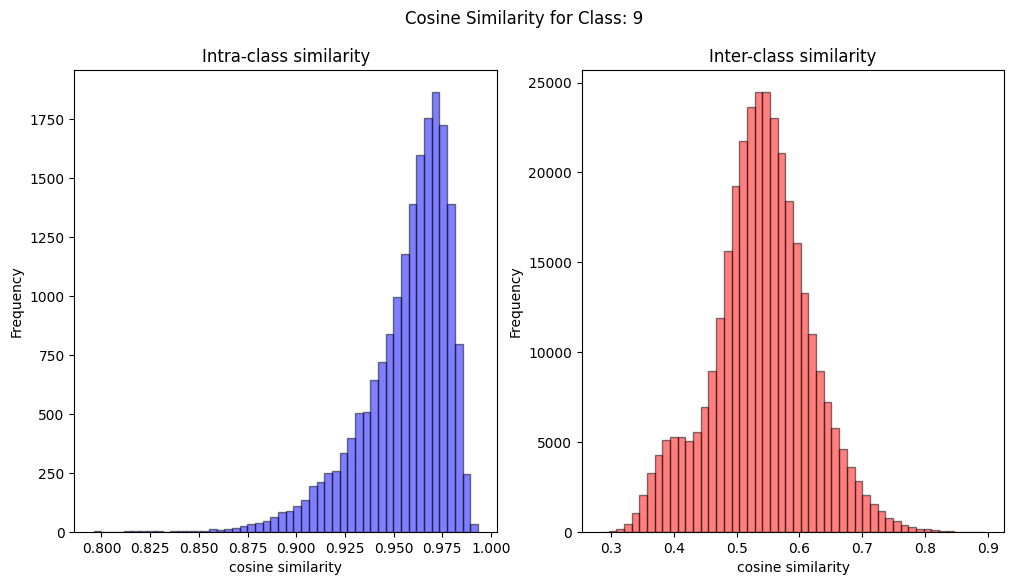

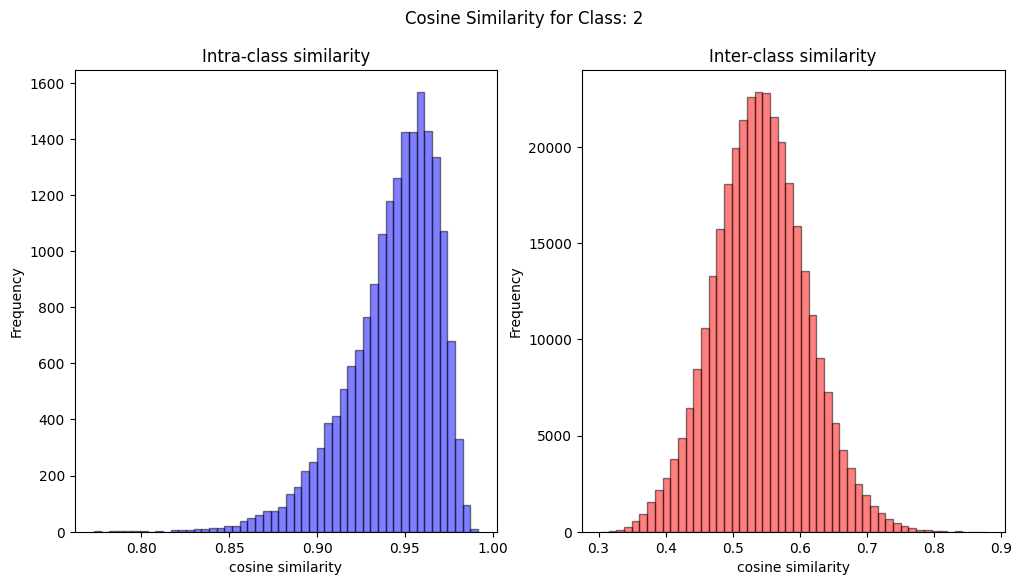

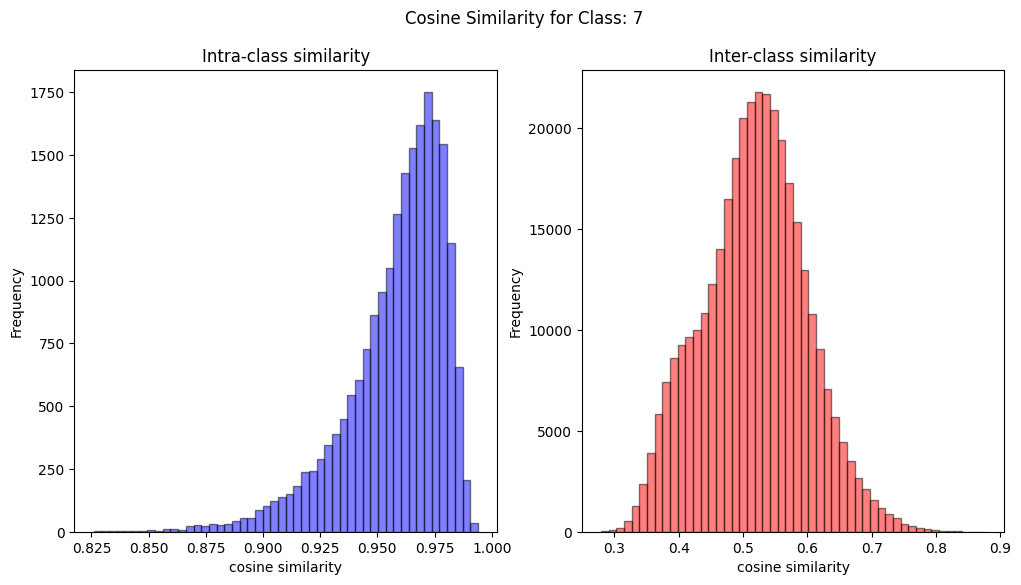

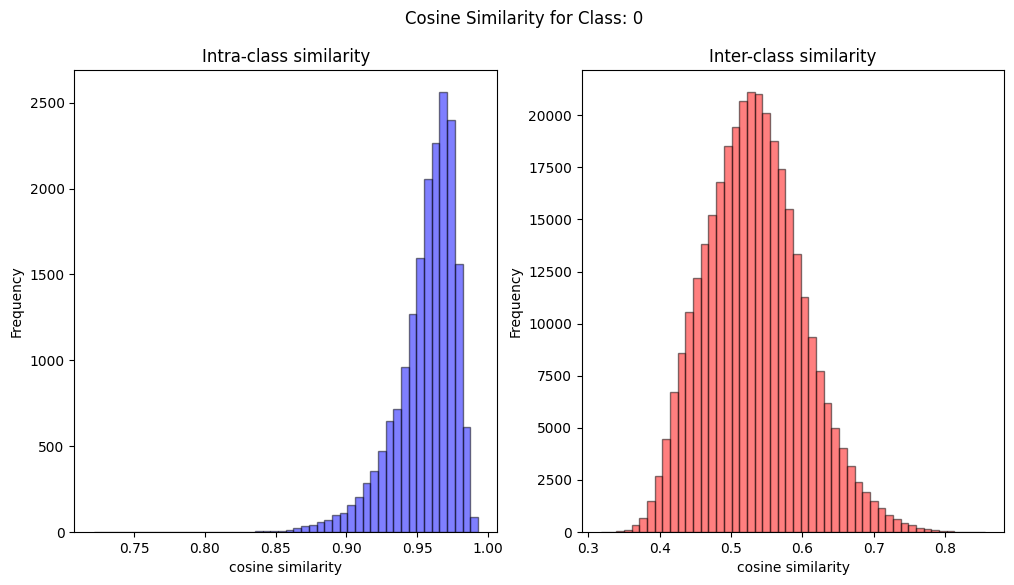

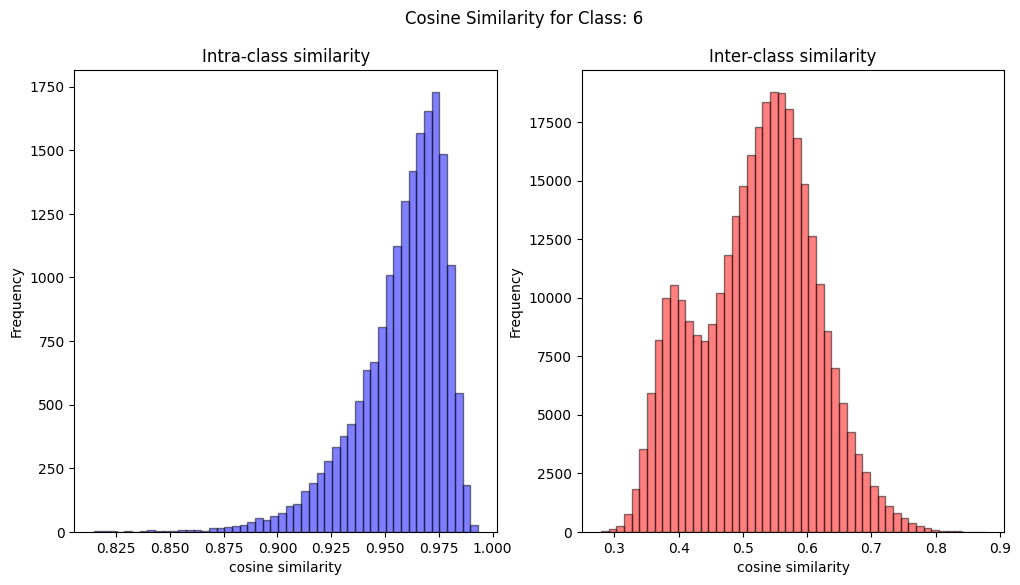

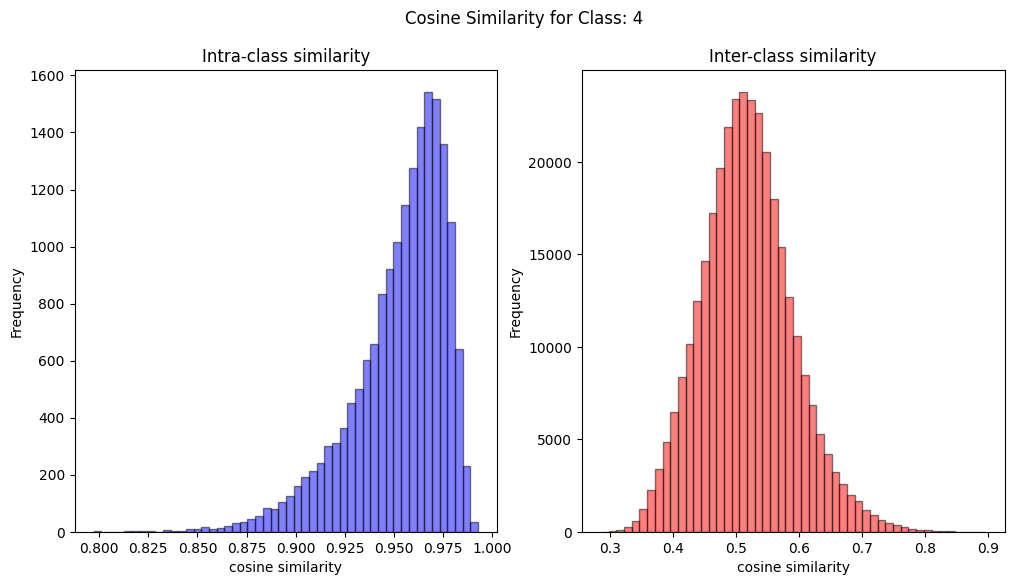

In [193]:
plot_hist(cos_sim_matrix)

In [11]:
def plot_scatter(cos_sim_matrix_np, sample_size=1000):
    for class_id in cos_sim_matrix_np:
        intra_sim_samples = np.random.choice(cos_sim_matrix_np[class_id]['intra_sim'], size=sample_size, replace=False)
        inter_sim_samples = np.random.choice(cos_sim_matrix_np[class_id]['inter_sim'], size=sample_size, replace=False)

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.scatter(range(len(intra_sim_samples)), intra_sim_samples, color='blue', alpha=0.5, label='intra-class similarity')
        ax.scatter(range(len(inter_sim_samples)), inter_sim_samples, color='red', alpha=0.5, label='inter-class similarity')
        ax.set_title(f"Scatter plot of cosine similarity for Class: {class_id}")
        ax.set_xlabel("Sample pair")
        ax.set_ylabel("cosine similarity")
        ax.legend()
        plt.show()



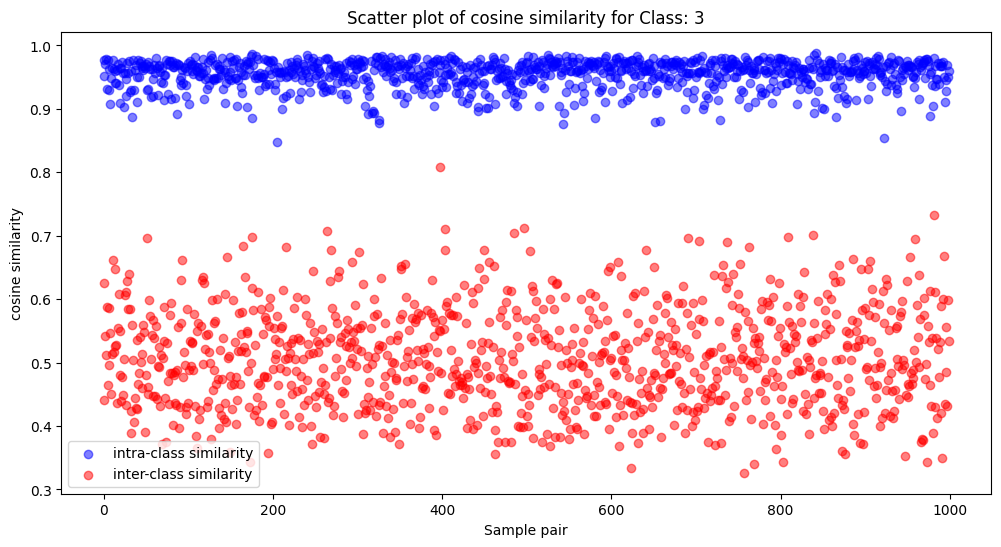

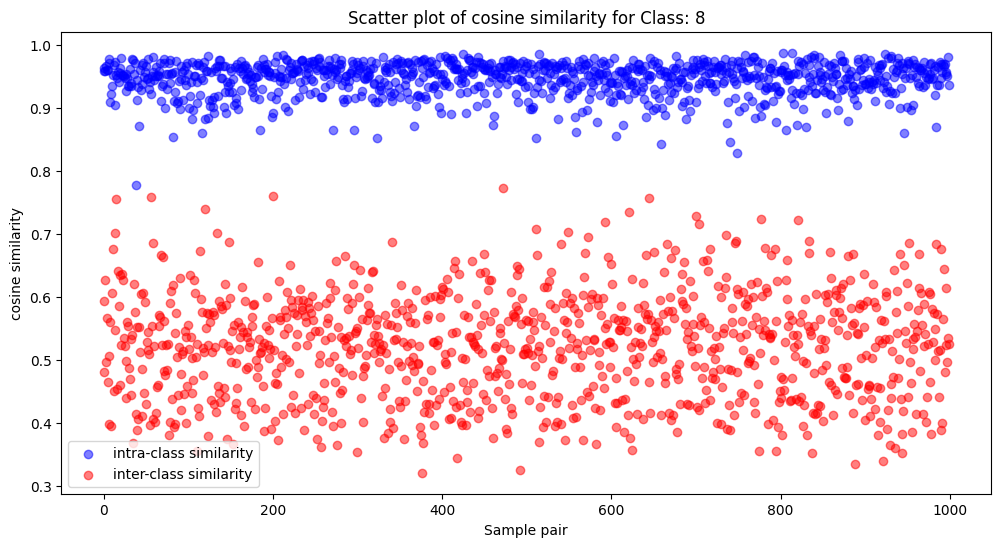

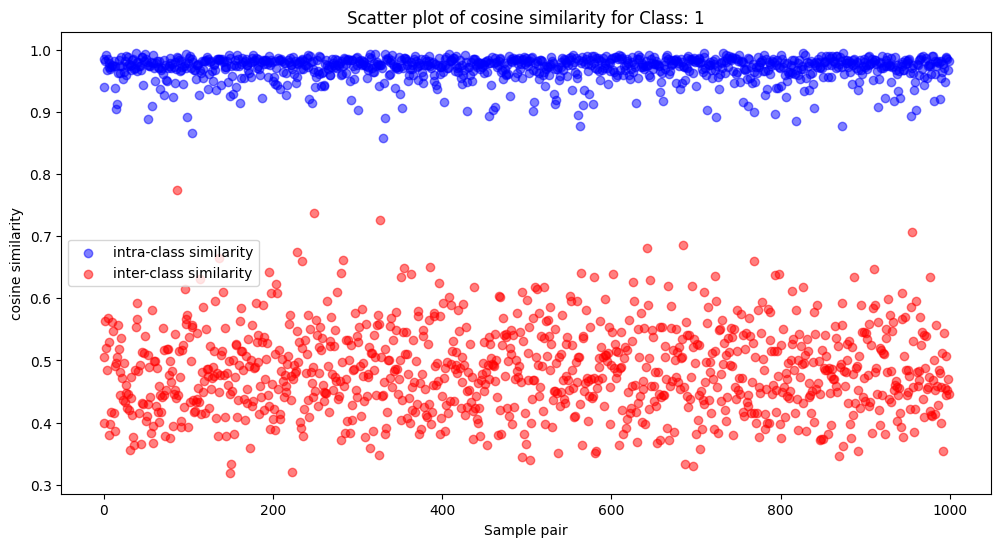

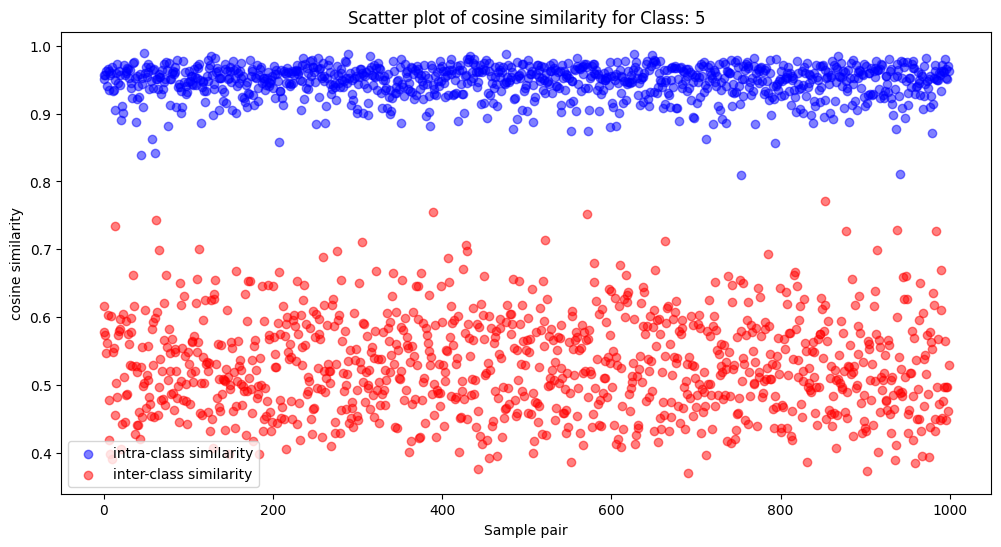

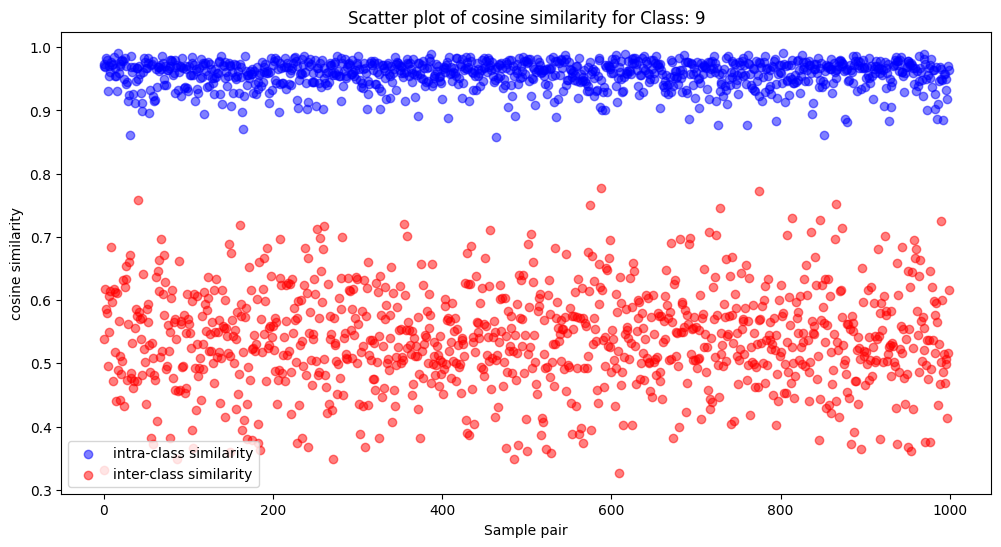

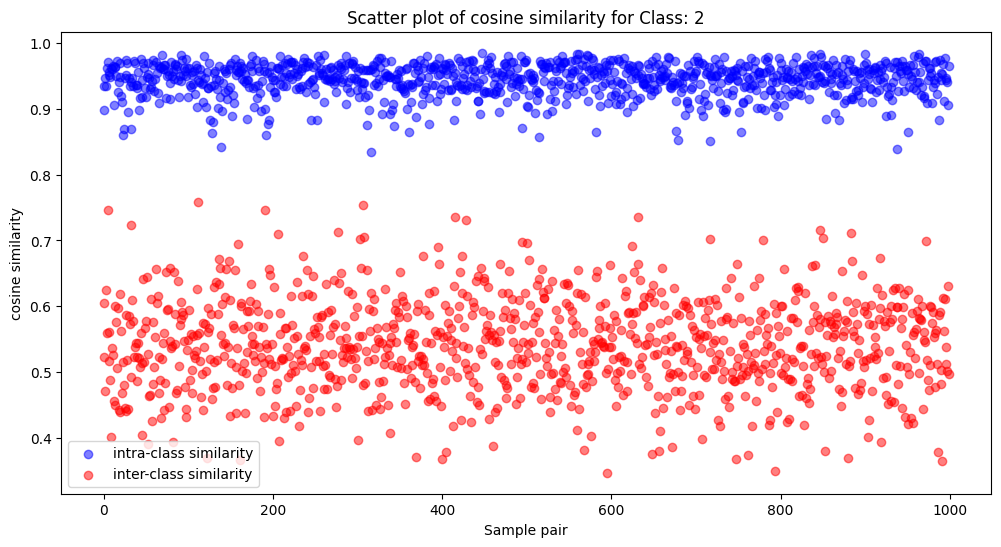

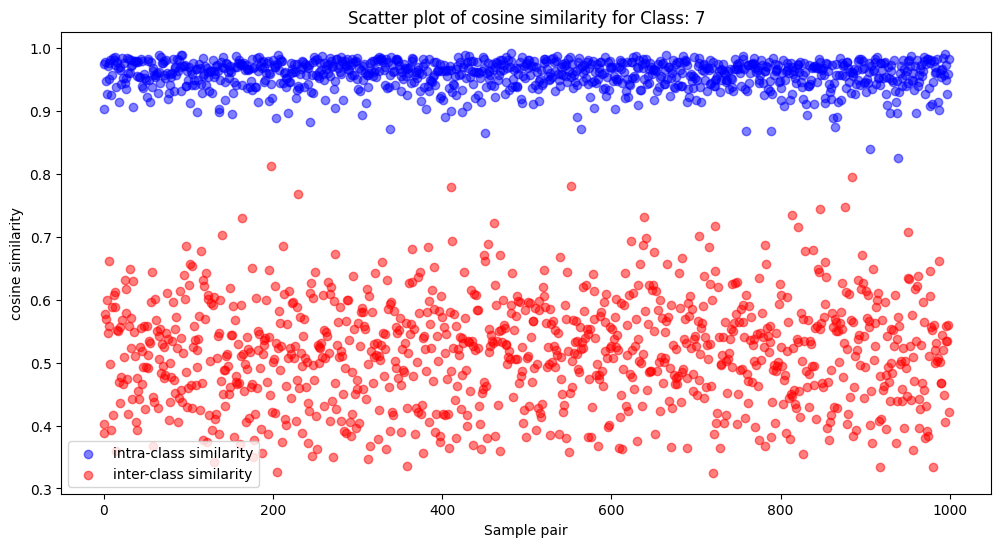

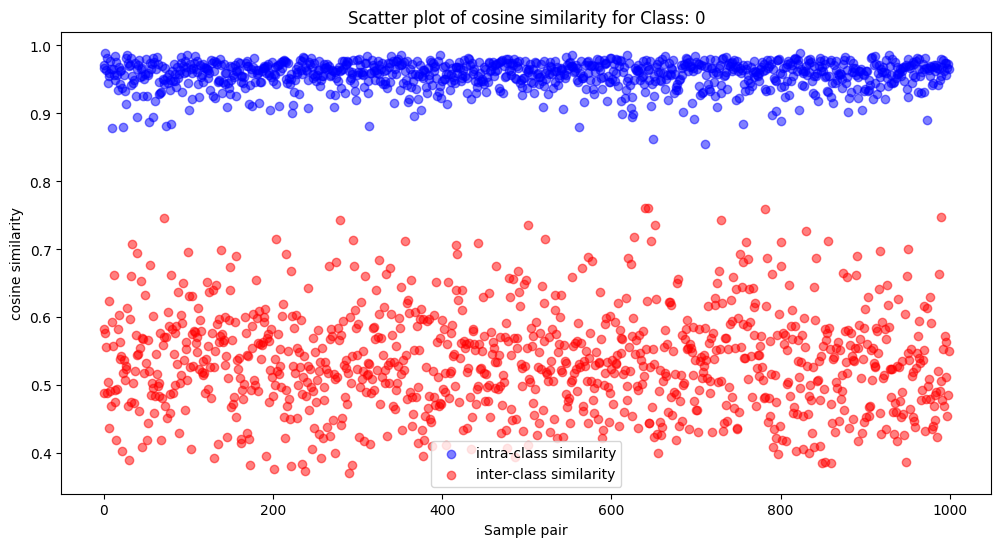

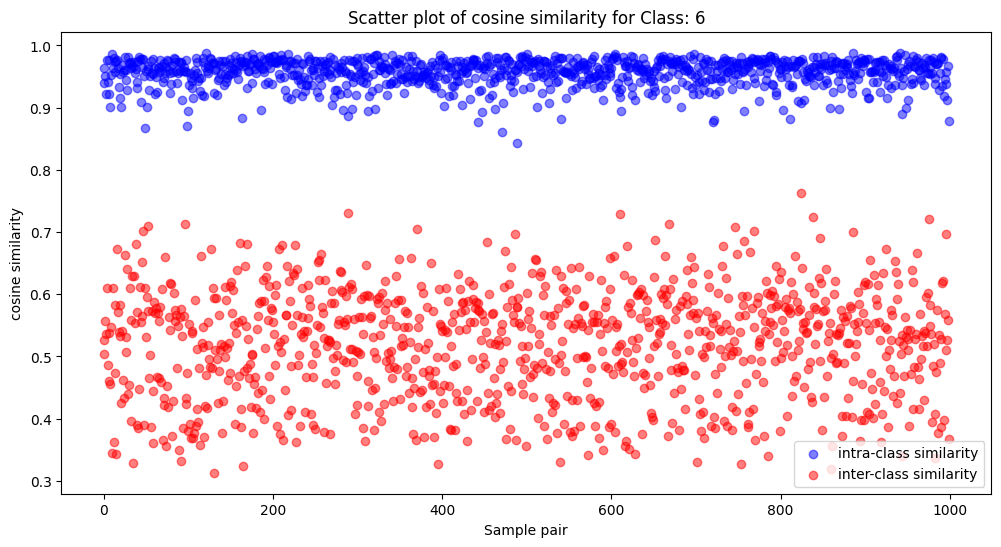

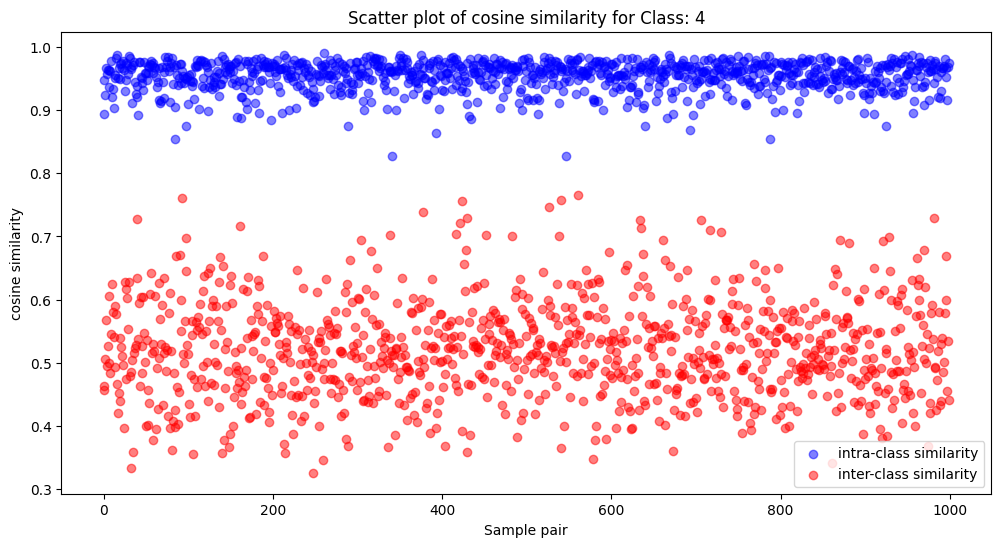

In [195]:
plot_scatter(cos_sim_matrix)

## Evaluate FSHN on MNIST

In [16]:
def eval(model, test_dataloader,dataset_name, num_epochs):
    model.eval()
    model.load_state_dict(torch.load(f'model_{dataset_name}_epoch_{num_epochs+1}.pth'))
    model.to(device)
    with torch.no_grad():
        feature_vectors, labels_list = [], []
        correct, total = 0,0
        for images, labels in test_dataloader:

            images = images.to(device) #images
            labels = labels.to(device) #true labels
            features, outputs = model(images) #TODO which one returns 
            feature_vectors.append(features)  # Append the features to the list
            #labels_list.append(labels)  # Append the labels to the list

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        feature_vectors = torch.cat(feature_vectors, dim=0)  # Concatenate the feature vectors
        #labels_list = torch.cat(labels_list, dim=0)  # Concatenate the labels

        accuracy = 100 * correct / total
        print('Accuracy: {:.2f}%'.format(accuracy))
        print('Feature Vectors:', feature_vectors)
        #print('Labels:', labels_list)

        return feature_vectors


In [13]:
fshn_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
fshn_test_dataloader = torch.utils.data.DataLoader(fshn_test_dataset, batch_size=64, shuffle=True)

In [17]:
fv = eval(model, fshn_test_dataloader, 'mnist',num_epochs)

Accuracy: 10.37%
Feature Vectors: tensor([[ 0.3824, 12.9057,  0.1185,  ...,  2.9455,  7.1822,  1.0425],
        [ 2.0810,  1.3139,  1.8001,  ...,  3.4154,  0.9095,  0.9322],
        [ 0.2211,  2.8155,  0.3859,  ...,  1.4764,  2.3754,  0.9091],
        ...,
        [ 1.1238,  2.7642,  0.0686,  ...,  2.1743,  0.9452,  0.2868],
        [ 0.8277,  6.2971,  0.0000,  ...,  2.7985,  2.4358,  0.4138],
        [ 0.5021,  0.0254,  2.7203,  ...,  0.0446,  2.2416,  1.2805]],
       device='cuda:0')


In [18]:
fshn_eval_cos_sim_matrix = cos_sim(model, fshn_test_dataloader, 'mnist', num_epochs)

Class 5:
Intra-class Similarity: Mean = 0.8098085525056637, Std = 0.10267590222732254, Var = 0.010542340898194698
Inter-class similarity: Mean = 0.7178980519523016, Std = 0.12136628130726877, Var = 0.014729774238355097

Class 9:
Intra-class Similarity: Mean = 0.8357111769960301, Std = 0.09829255707033906, Var = 0.009661426775425861
Inter-class similarity: Mean = 0.7583030185116444, Std = 0.11276546861841498, Var = 0.012716050912730734

Class 4:
Intra-class Similarity: Mean = 0.8572490207518024, Std = 0.12648402402950792, Var = 0.015998208334697138
Inter-class similarity: Mean = 0.7830196624132608, Std = 0.13620224833595995, Var = 0.01855105245177051

Class 7:
Intra-class Similarity: Mean = 0.865003547902876, Std = 0.08335784651007451, Var = 0.006948530574797142
Inter-class similarity: Mean = 0.7120865540598917, Std = 0.11262529935491594, Var = 0.012684458054784428

Class 6:
Intra-class Similarity: Mean = 0.8207064657169514, Std = 0.15393332097360365, Var = 0.023695467305962486
Inter-cl

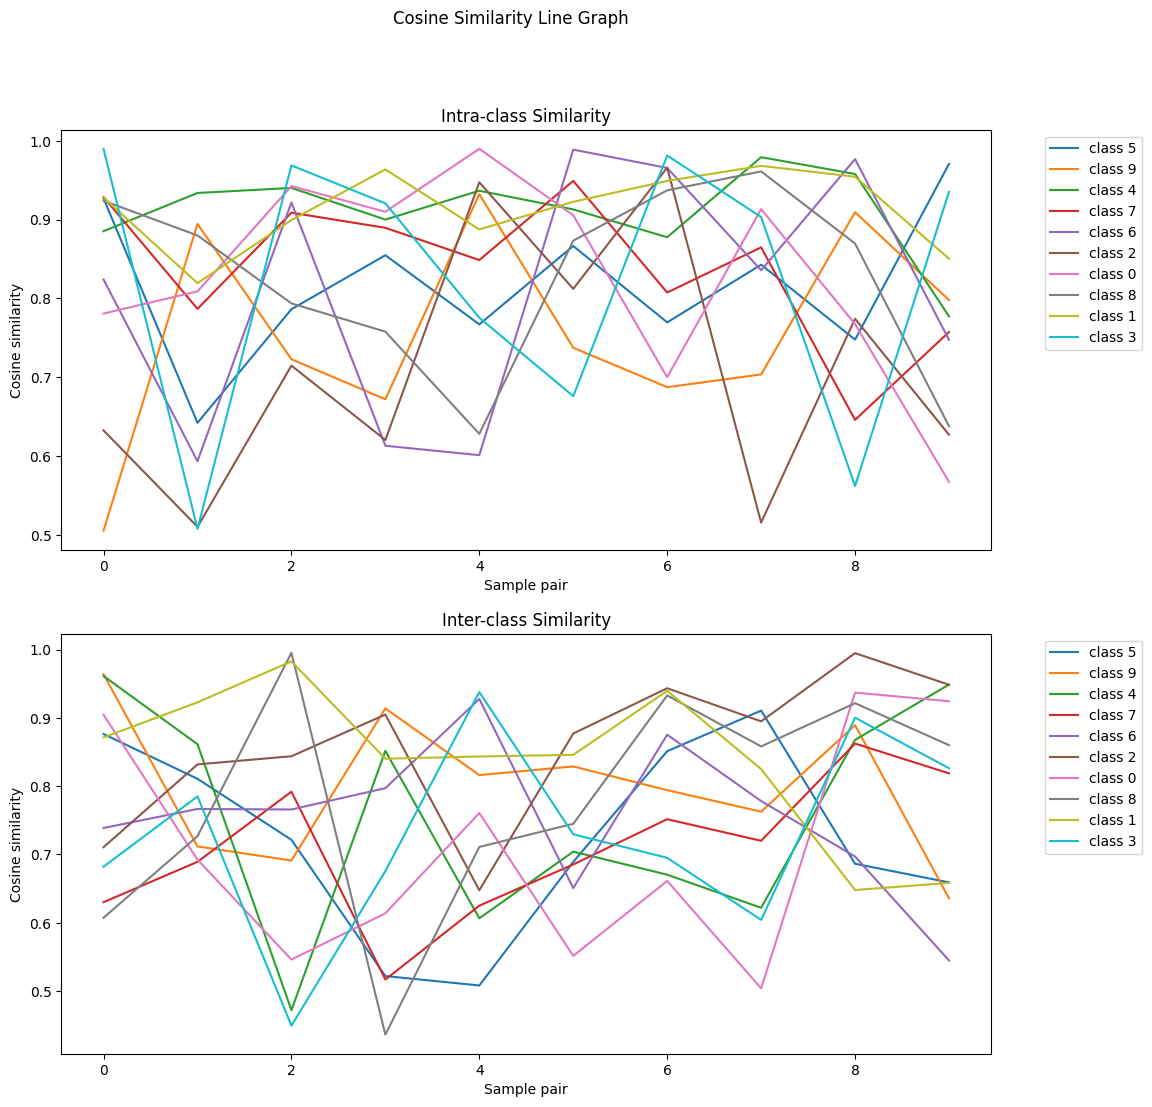

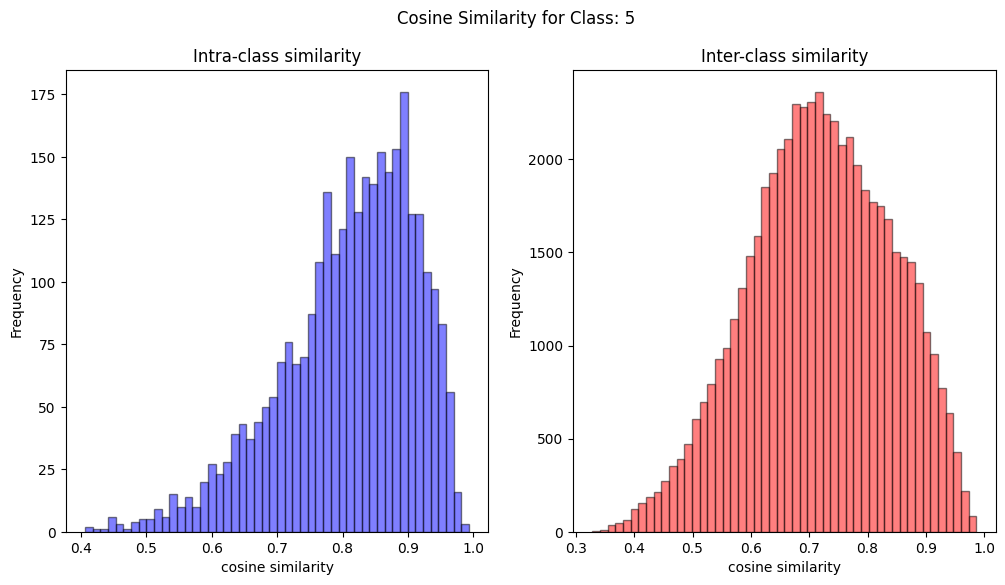

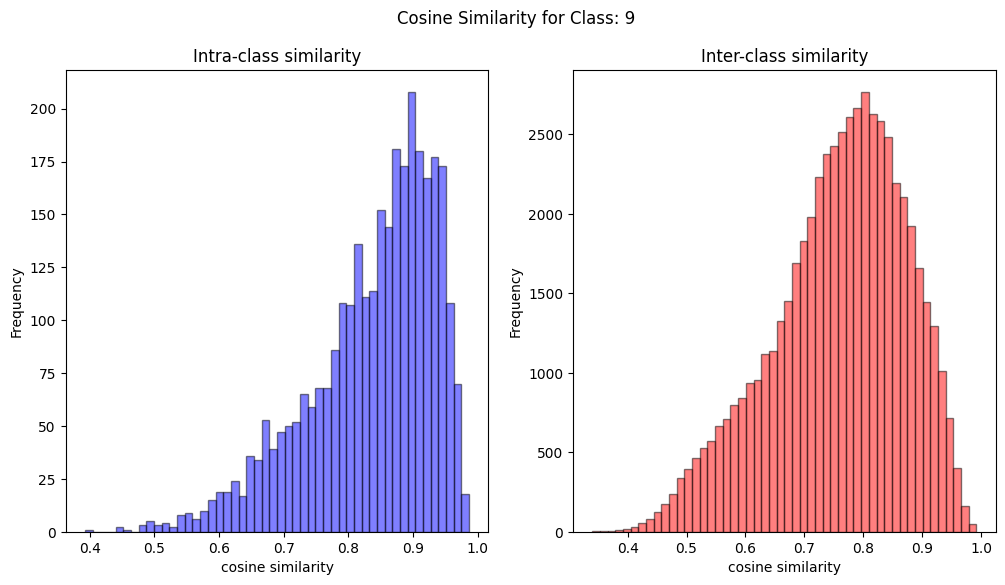

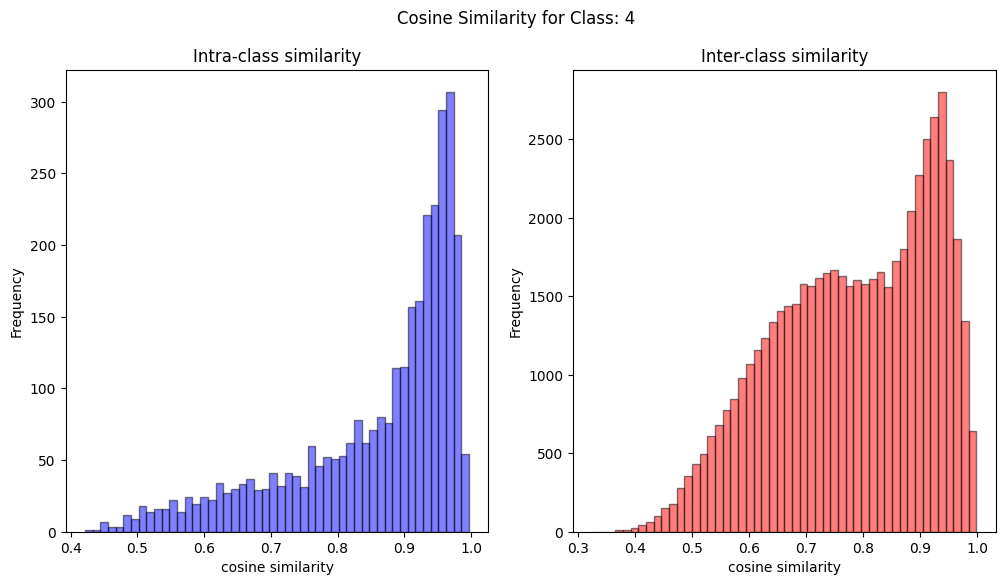

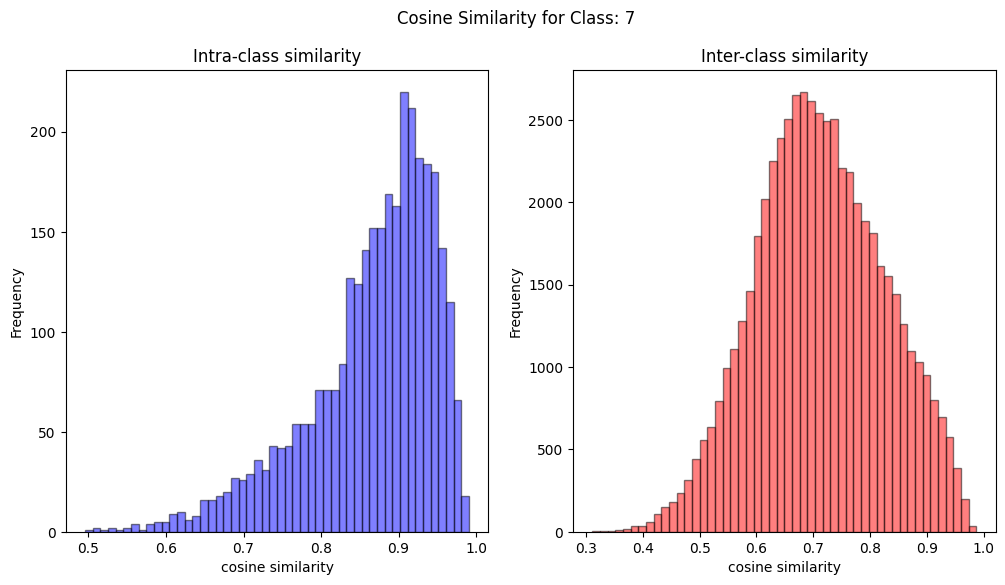

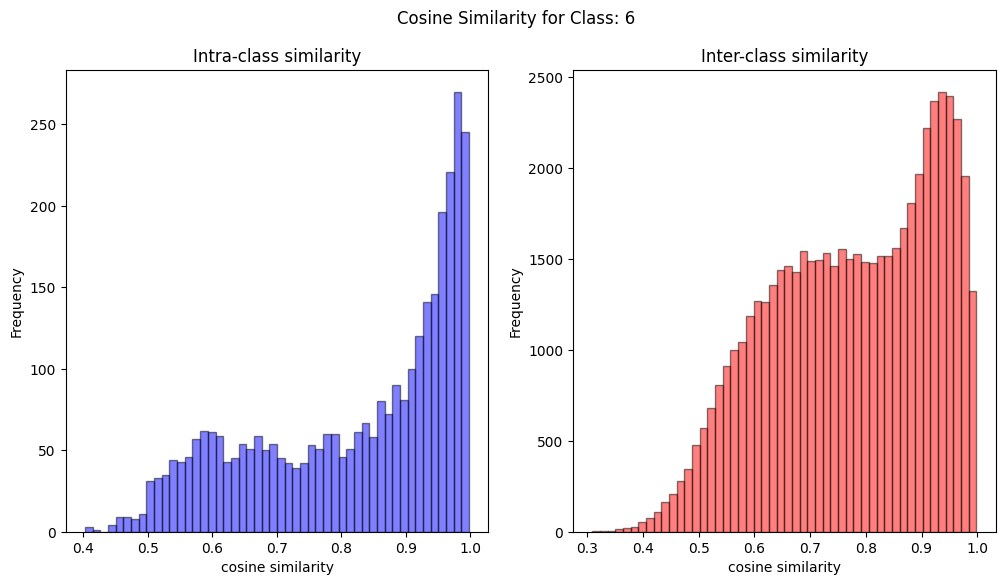

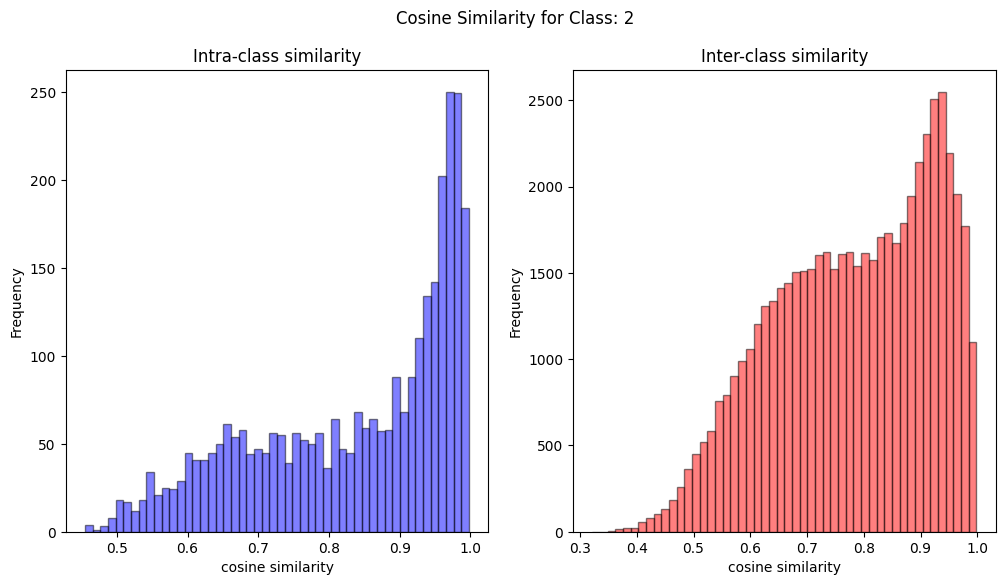

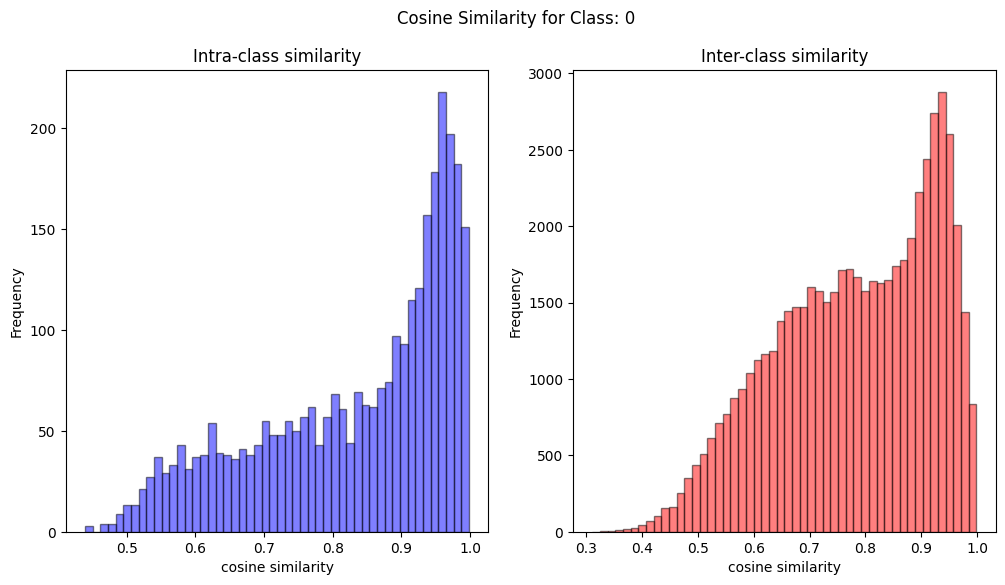

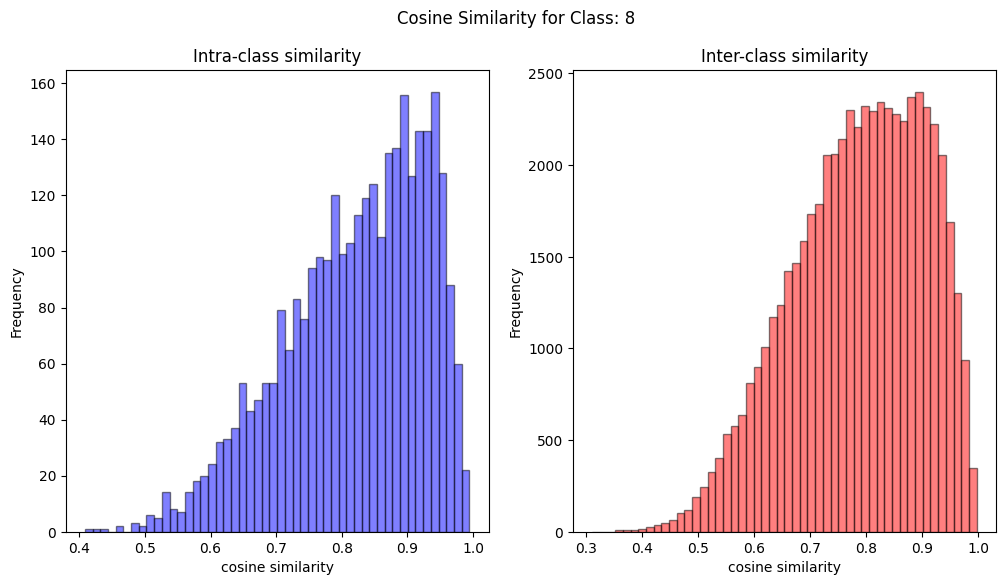

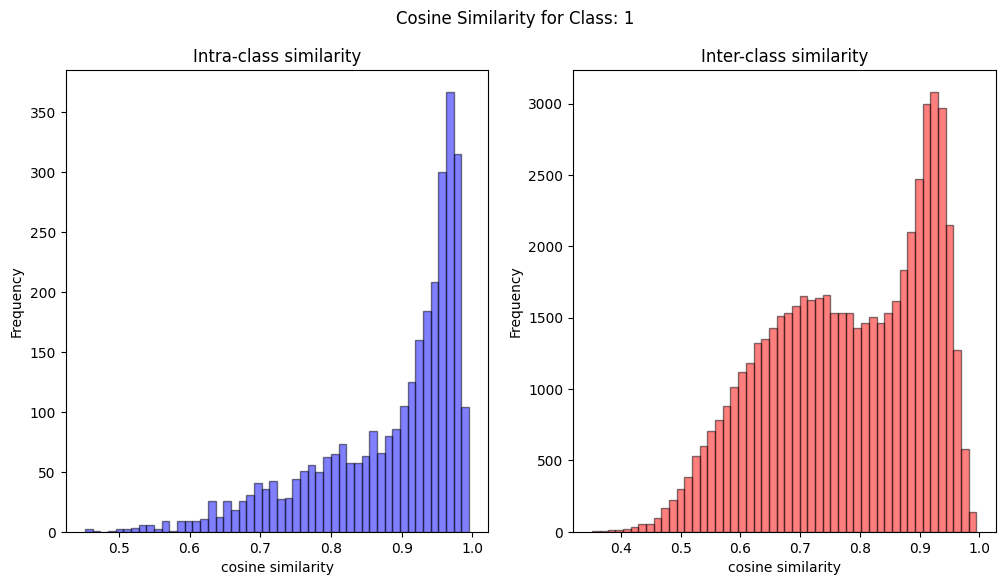

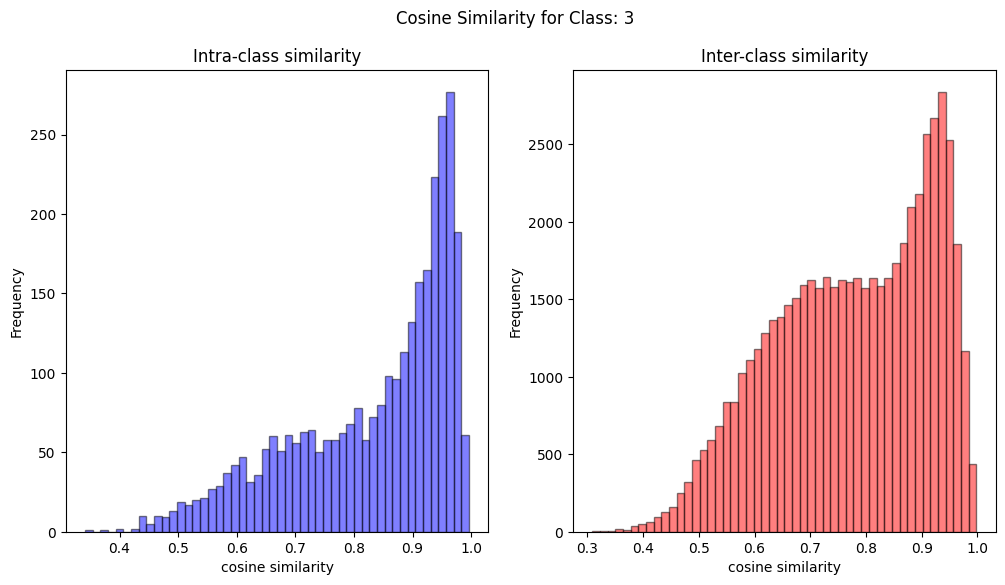

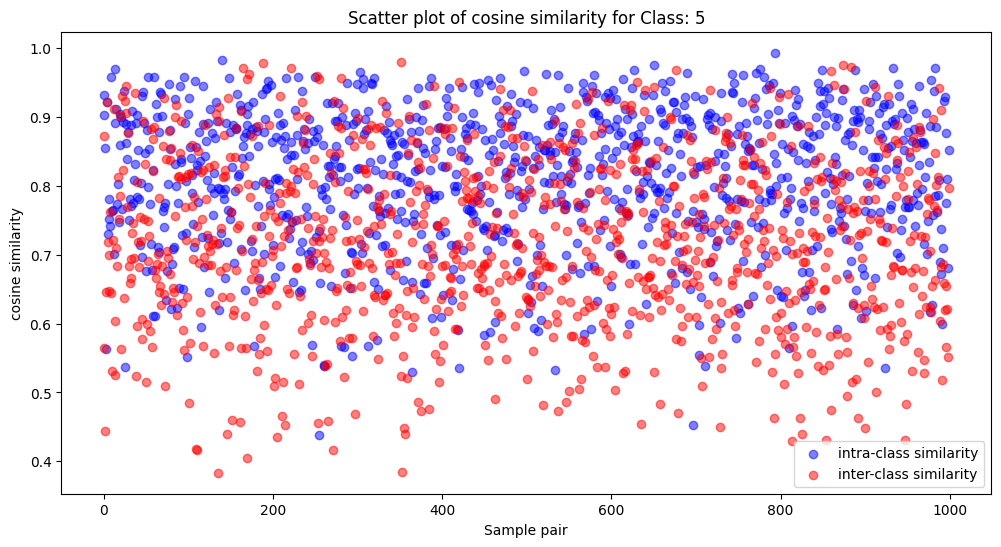

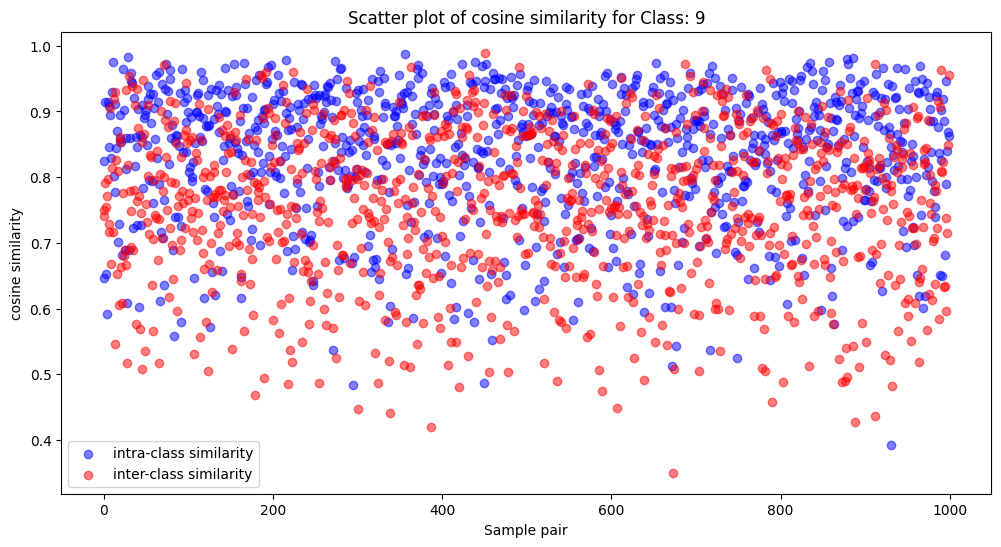

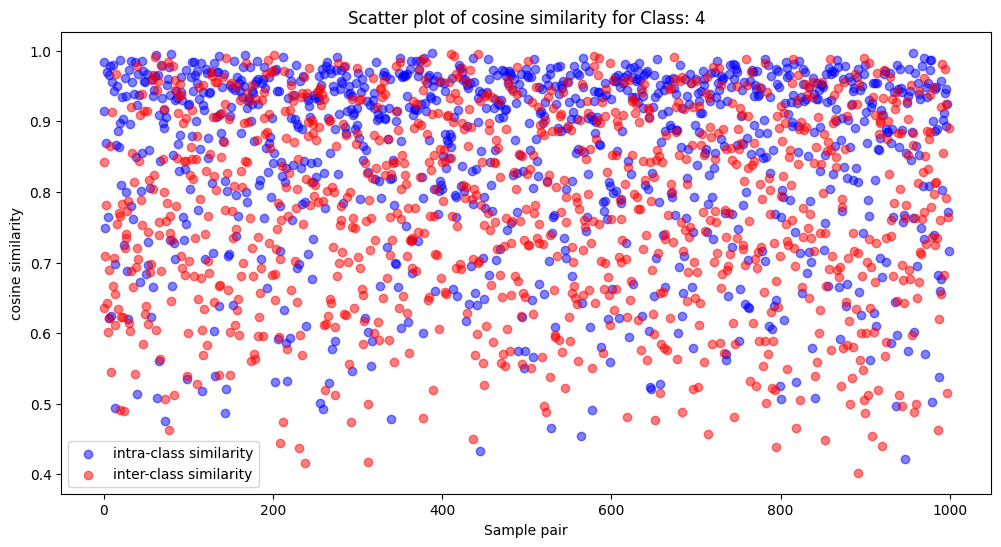

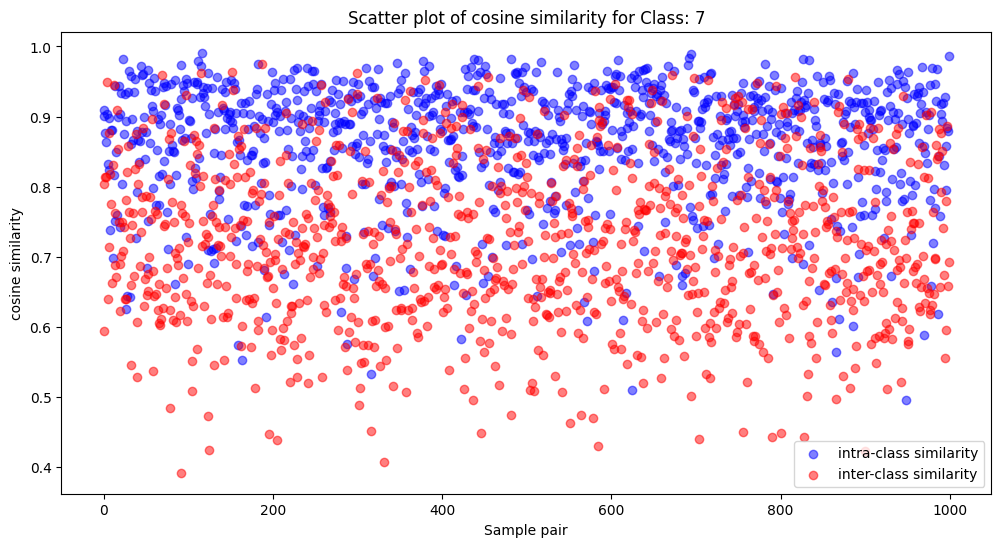

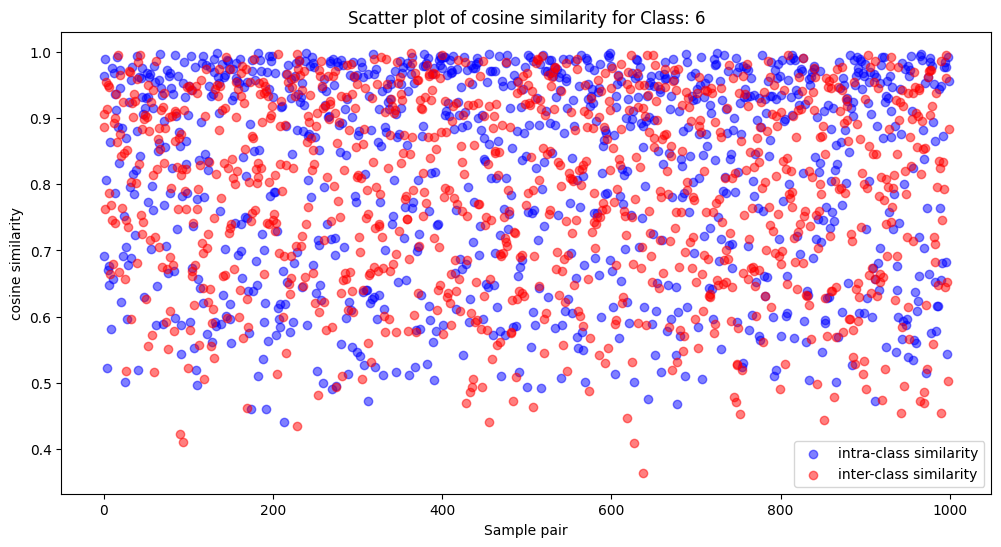

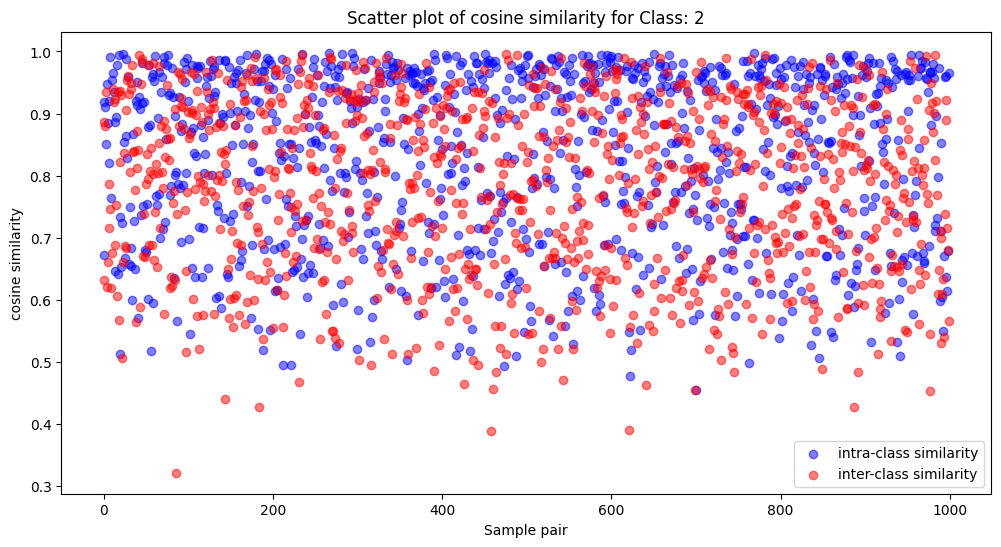

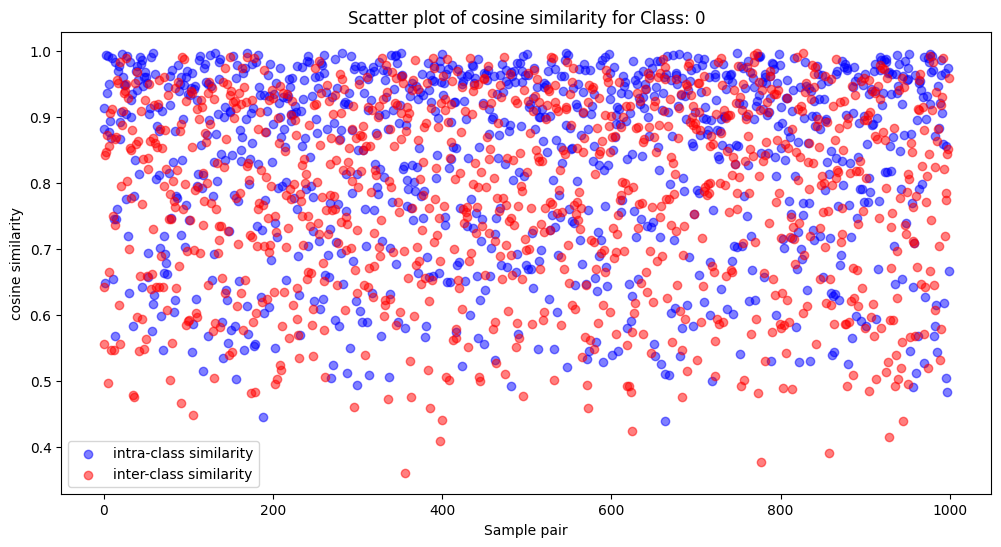

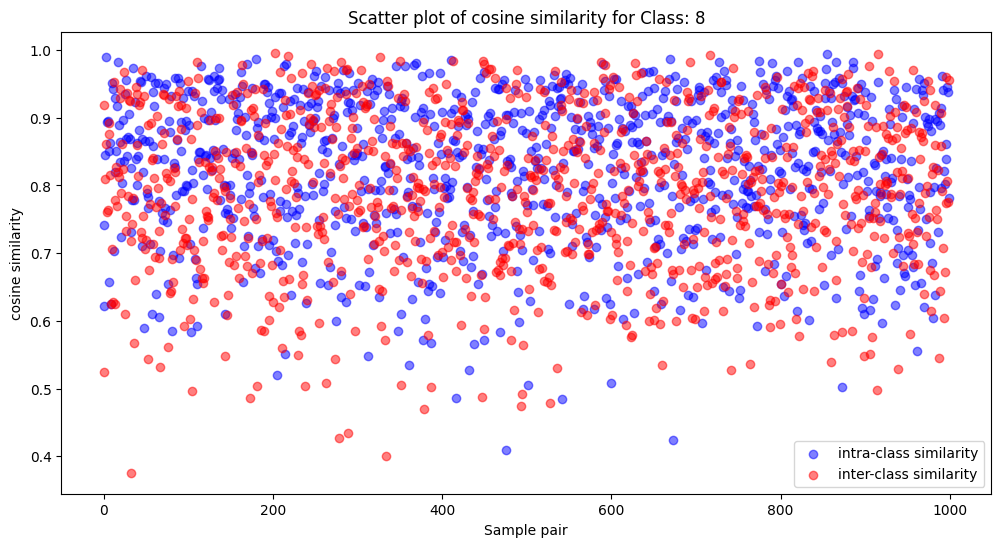

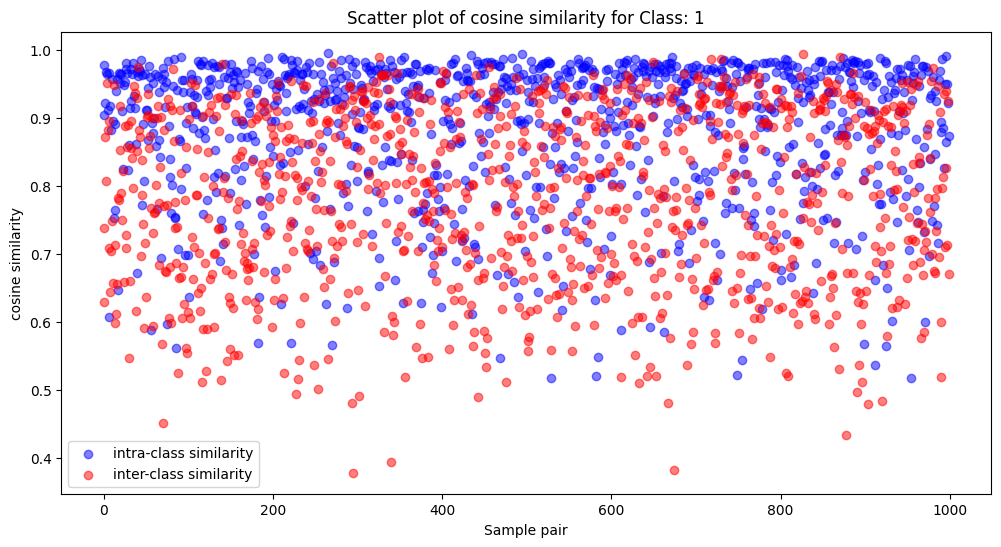

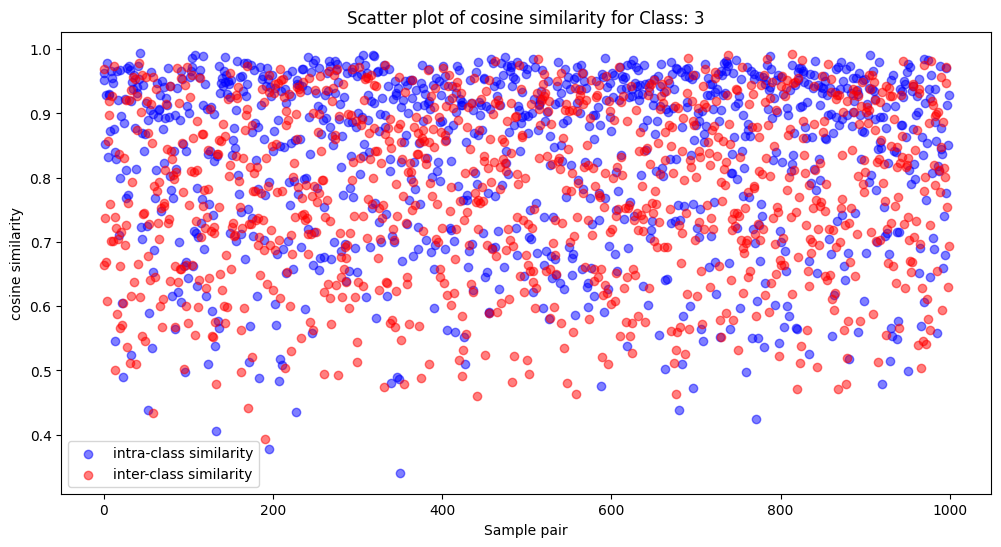

In [225]:
print_res(fshn_eval_cos_sim_matrix)
plot_line_graph(fshn_eval_cos_sim_matrix,10)
plot_hist(fshn_eval_cos_sim_matrix)
plot_scatter(fshn_eval_cos_sim_matrix)

## ResNet -- Cifar10
define new model parameters

In [199]:

# Define the data transformations
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training dataset
cifar_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create the data loader
cifar_train_loader = torch.utils.data.DataLoader(cifar_train_dataset, batch_size=64, shuffle=True)

# Define the number of classes
cifar_nclass = 10
cifar_scale = 32
cifar_channels = 3

# Create an instance of ResNet18 model
cifar_model = ResNet18(cifar_nclass, cifar_scale, cifar_channels, proto_layer=4,layer_norm = False, entry_stride = 1).to(device)

#Define optimizer
cifar_optimizer = optim.SGD(cifar_model.parameters(), lr=0.01)

cifar_num_epochs = 50


Files already downloaded and verified
32


In [200]:
#train(cifar_model, cifar_train_loader, cifar_optimizer, 'cifar10', cifar_num_epochs)

In [201]:
cifar_cos_sim_matrix = cos_sim(cifar_model, cifar_train_loader, 'cifar10', cifar_num_epochs)

In [202]:
print_res(cifar_cos_sim_matrix)

Class 6:
Intra-class Similarity: Mean = 0.8565375145619659, Std = 0.05697435144709502, Var = 0.003246076722817099
Inter-class similarity: Mean = 0.5707809101128153, Std = 0.112518908517334, Var = 0.012660504773932177

Class 8:
Intra-class Similarity: Mean = 0.8690153078462575, Std = 0.05503741337565663, Var = 0.0030291168710829073
Inter-class similarity: Mean = 0.5605338827740105, Std = 0.10176252652428844, Var = 0.010355611804606509

Class 2:
Intra-class Similarity: Mean = 0.8354637630844526, Std = 0.06245107820732836, Var = 0.003900137169257844
Inter-class similarity: Mean = 0.6154138370240572, Std = 0.10345523563193043, Var = 0.01070298577965825

Class 4:
Intra-class Similarity: Mean = 0.8480899253575649, Std = 0.059302790903898374, Var = 0.003516821008991492
Inter-class similarity: Mean = 0.60969430322068, Std = 0.10496602971898426, Var = 0.011017867394966688

Class 0:
Intra-class Similarity: Mean = 0.8297380800393884, Std = 0.06457526375716, Var = 0.004169964689306781
Inter-class 

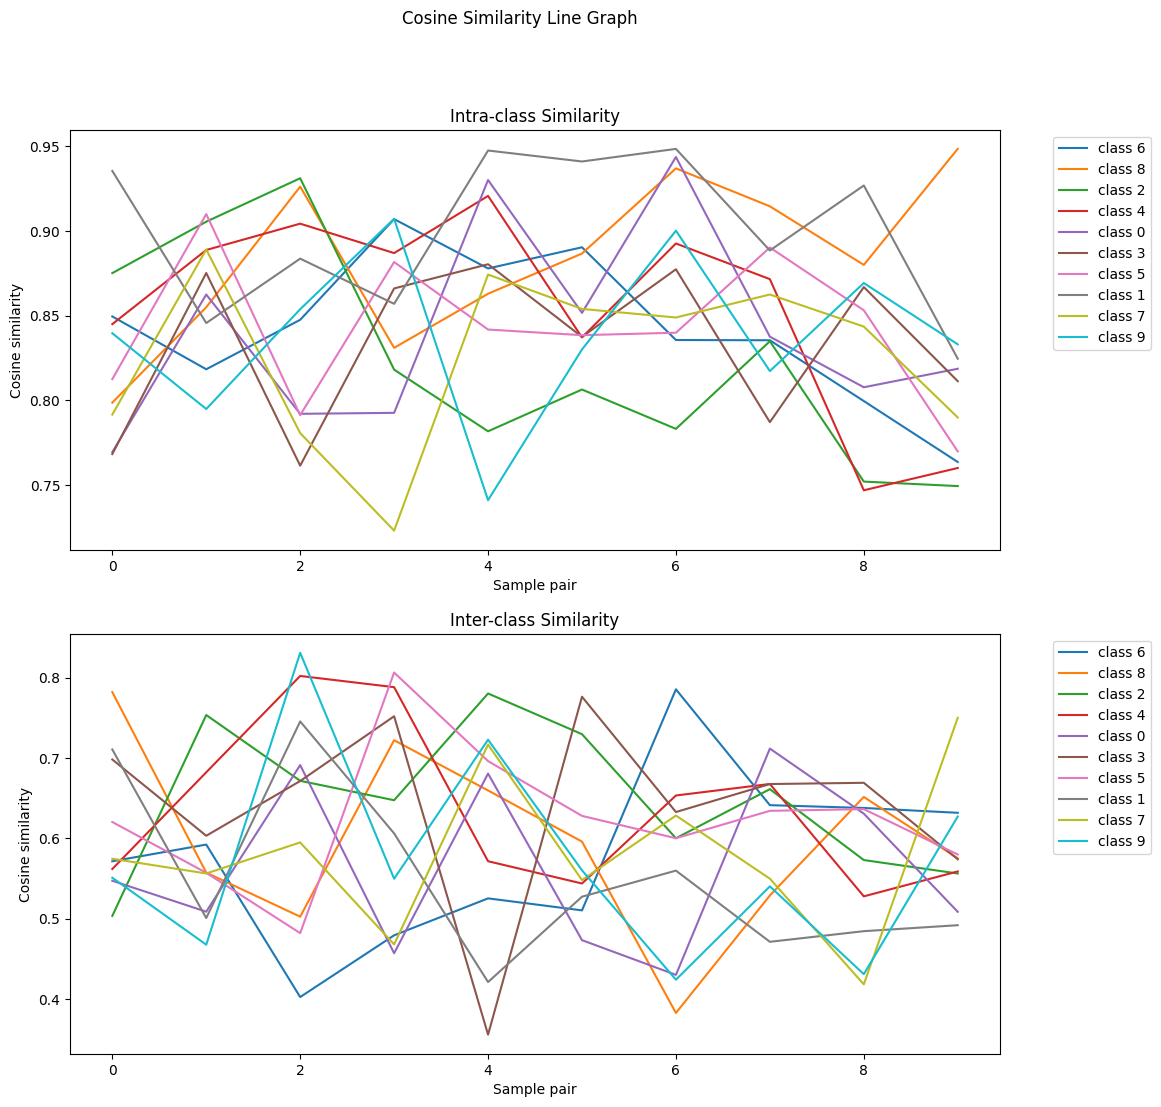

In [210]:
plot_line_graph(cifar_cos_sim_matrix,10)

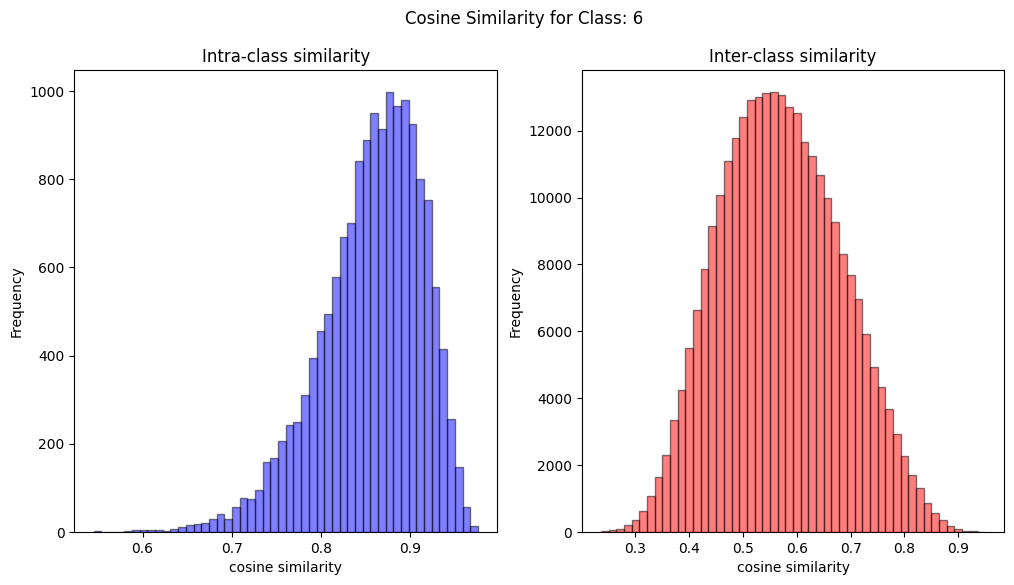

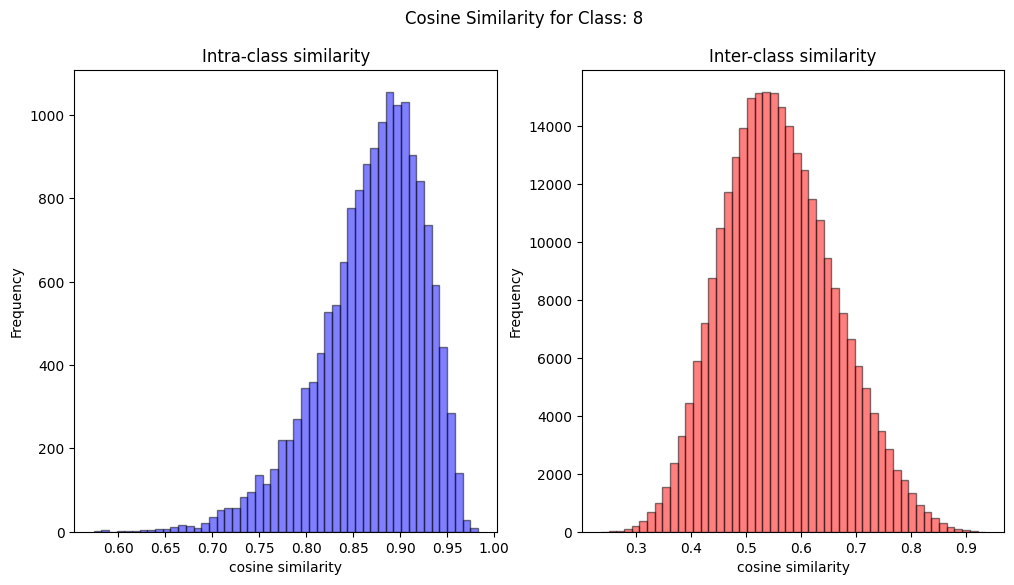

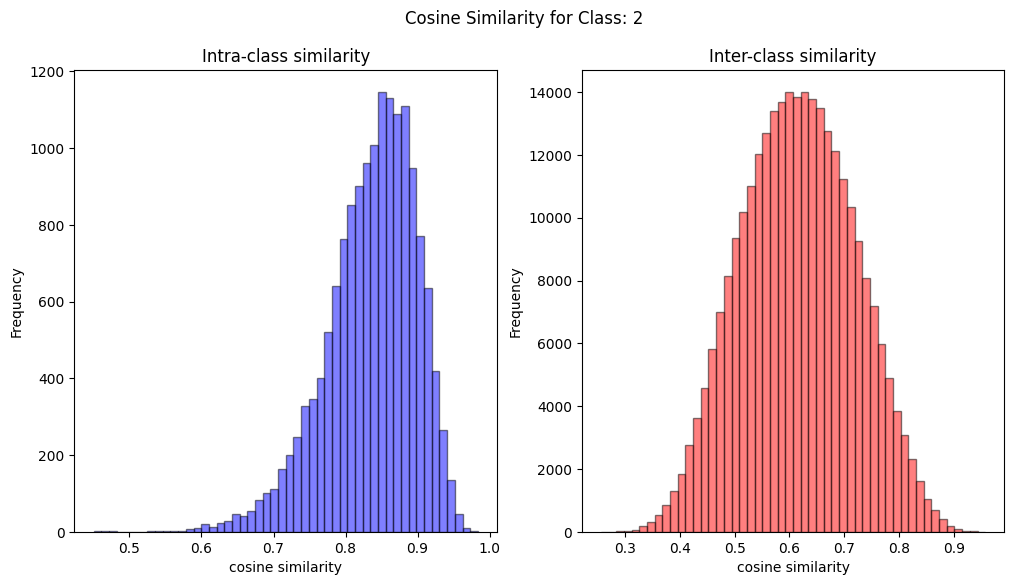

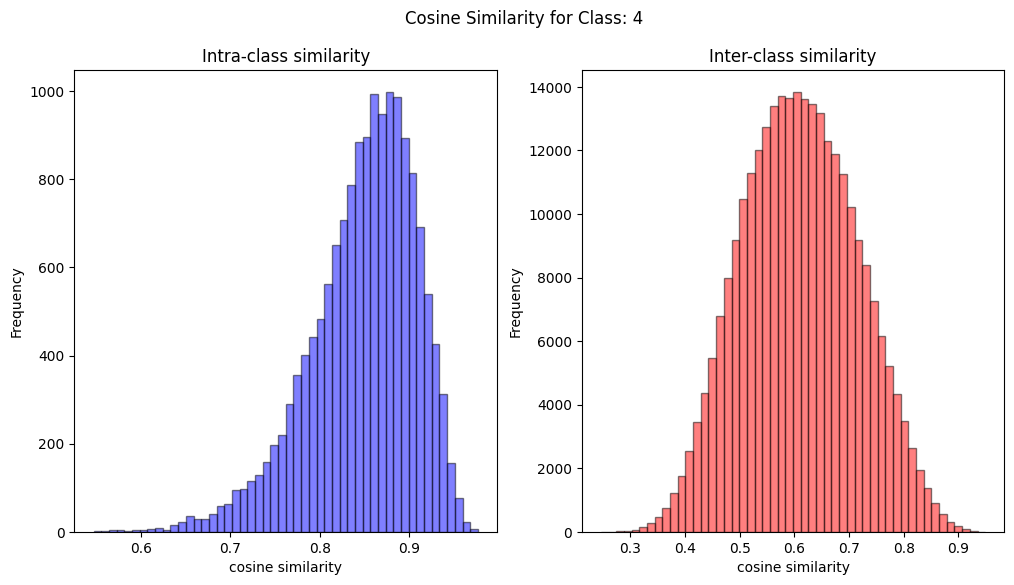

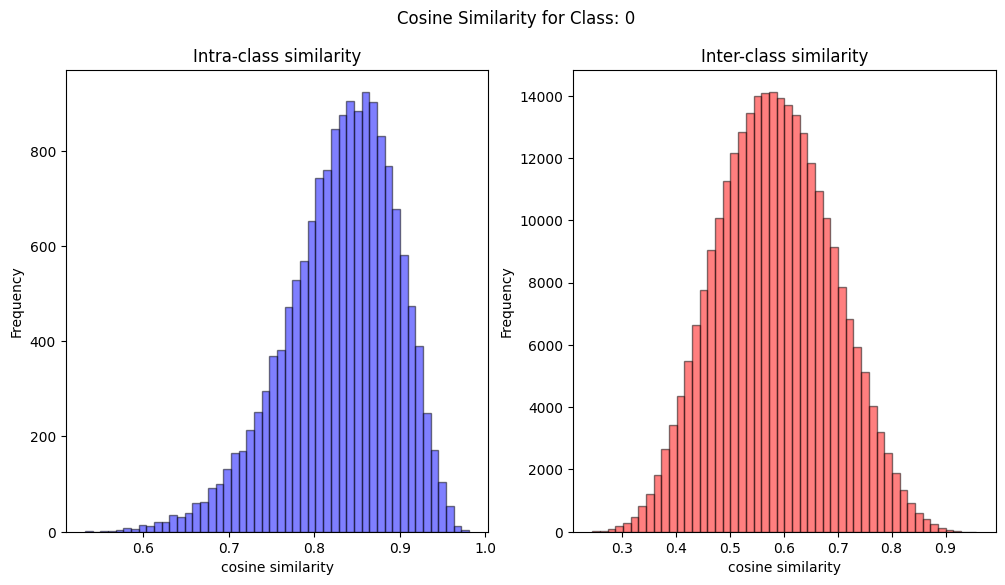

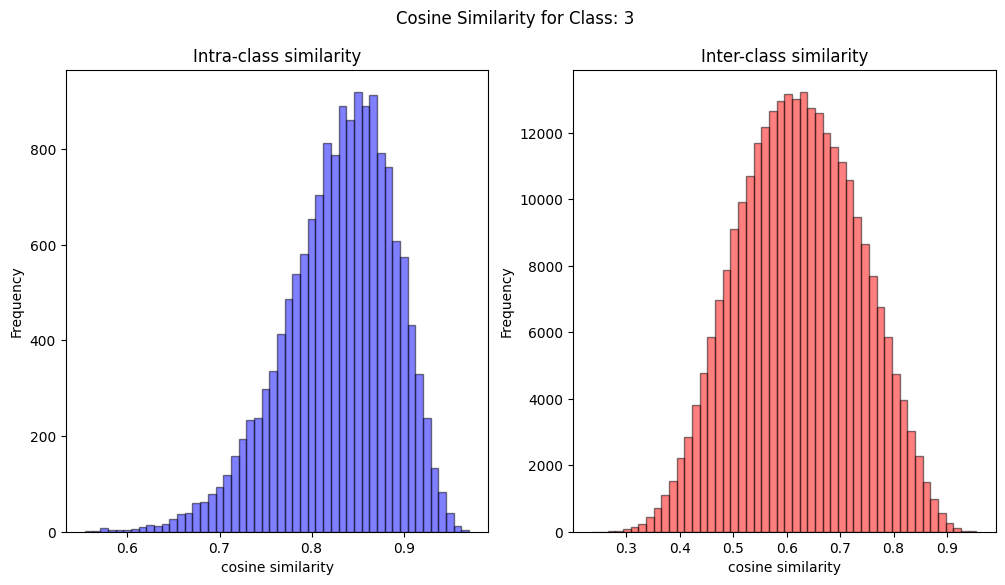

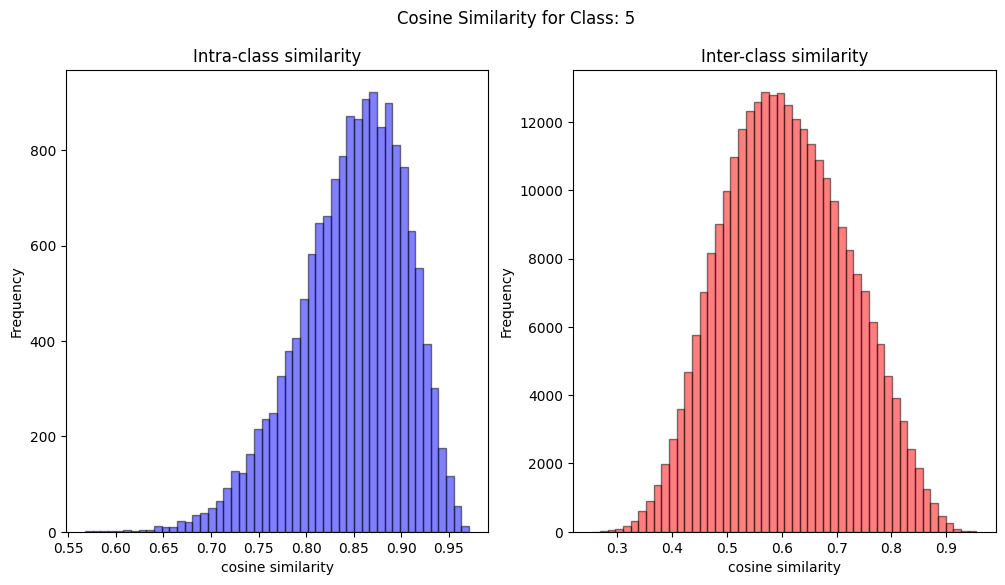

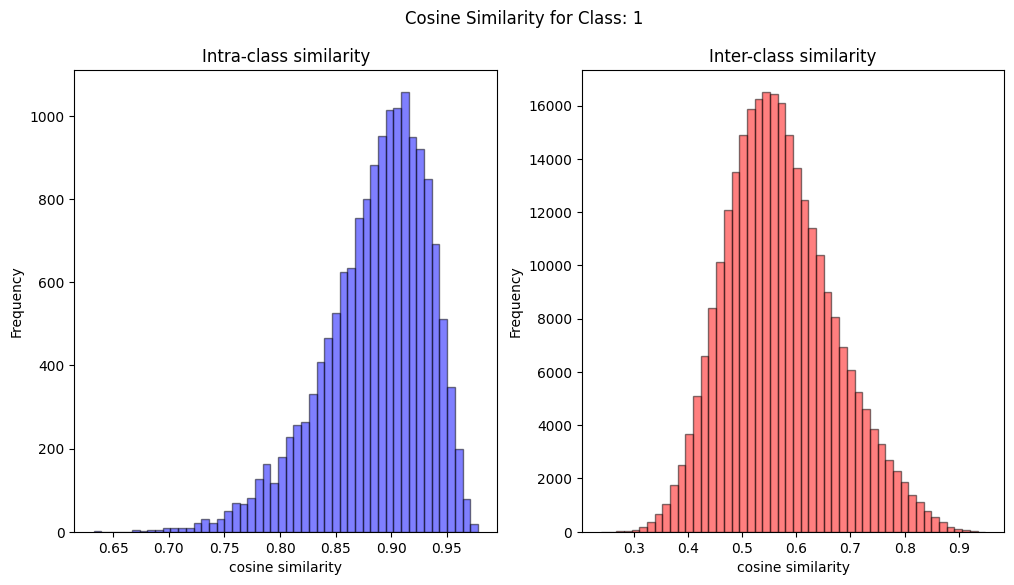

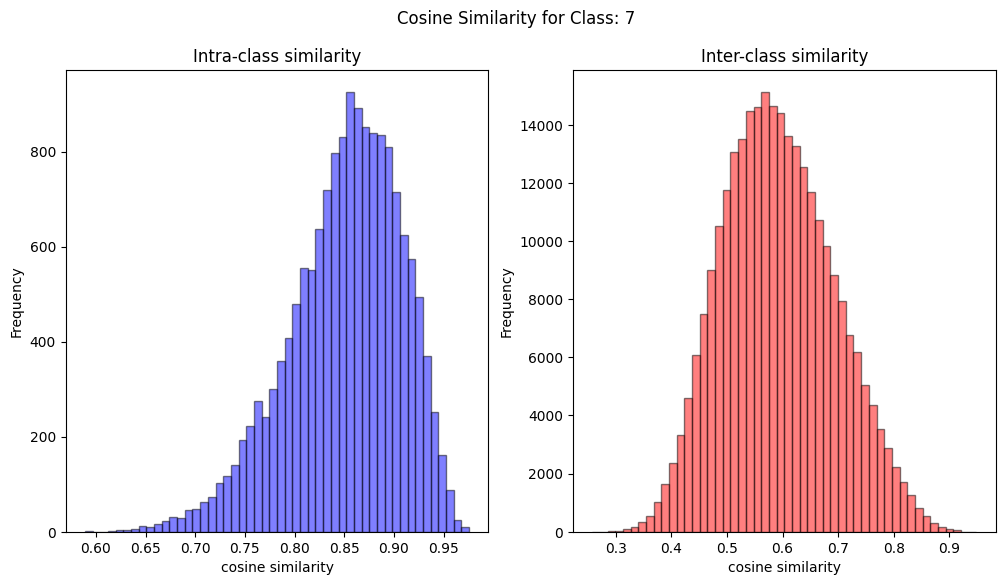

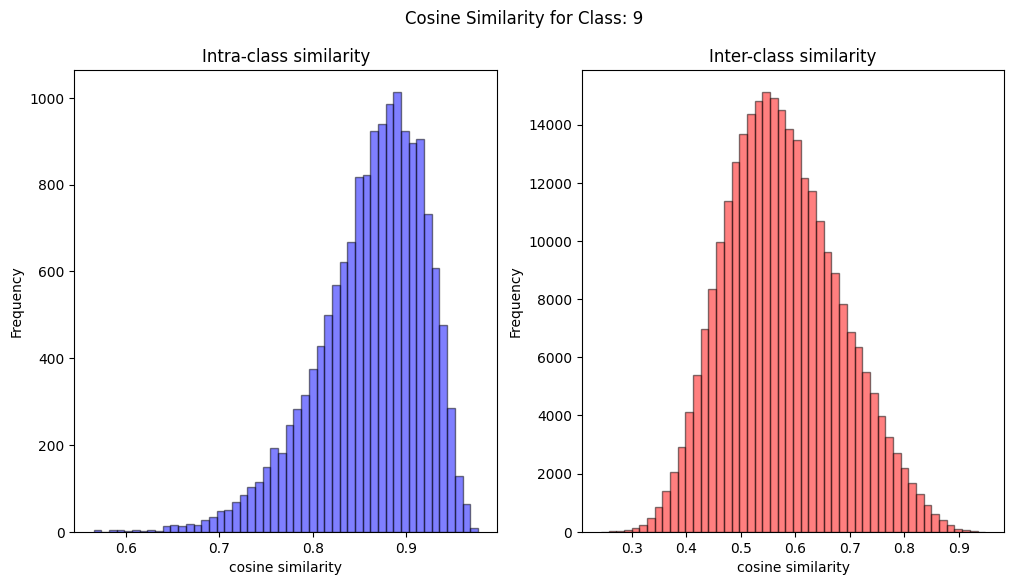

In [204]:
plot_hist(cifar_cos_sim_matrix)

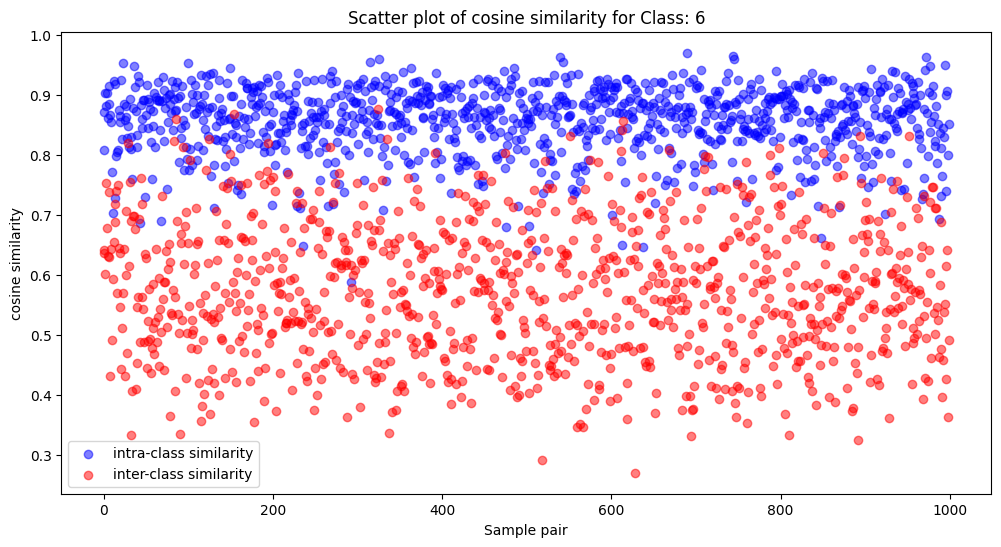

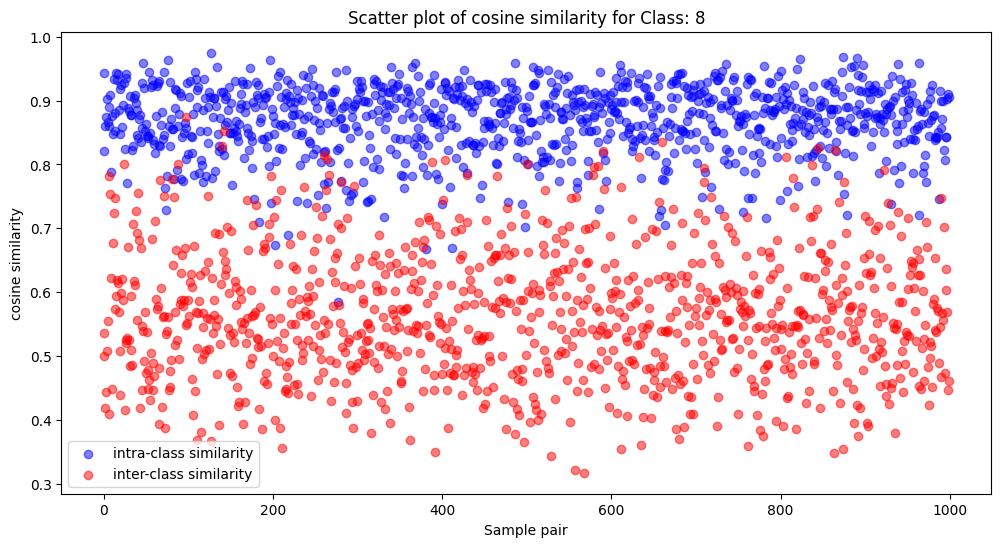

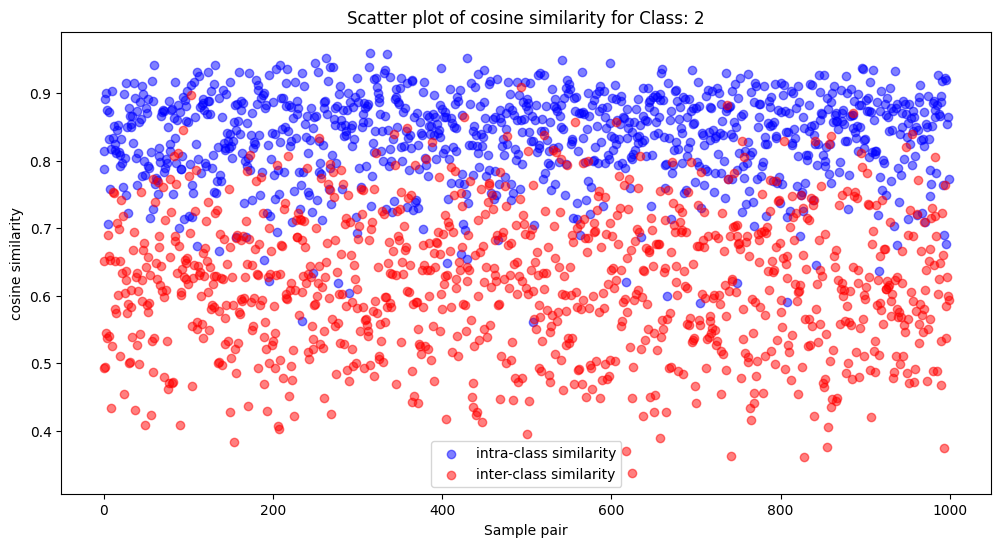

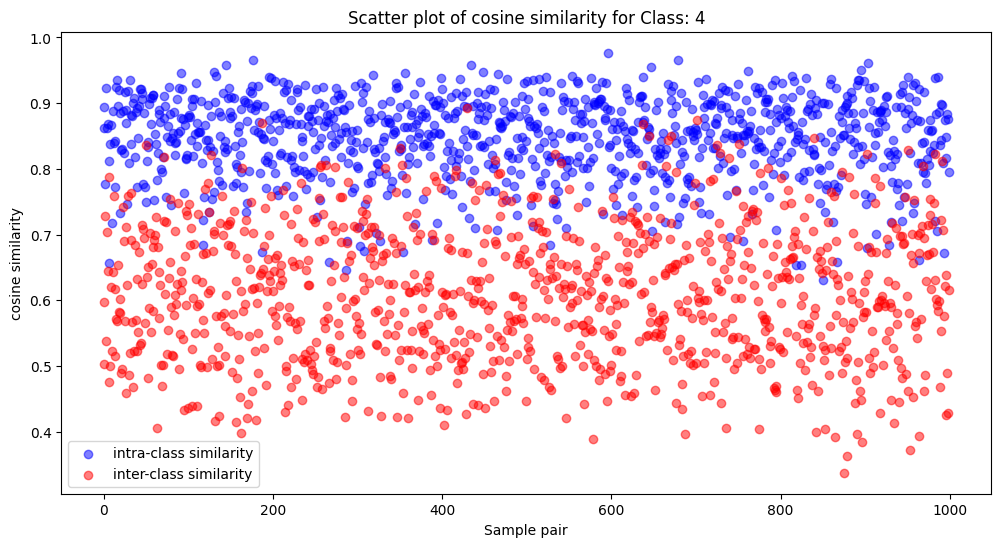

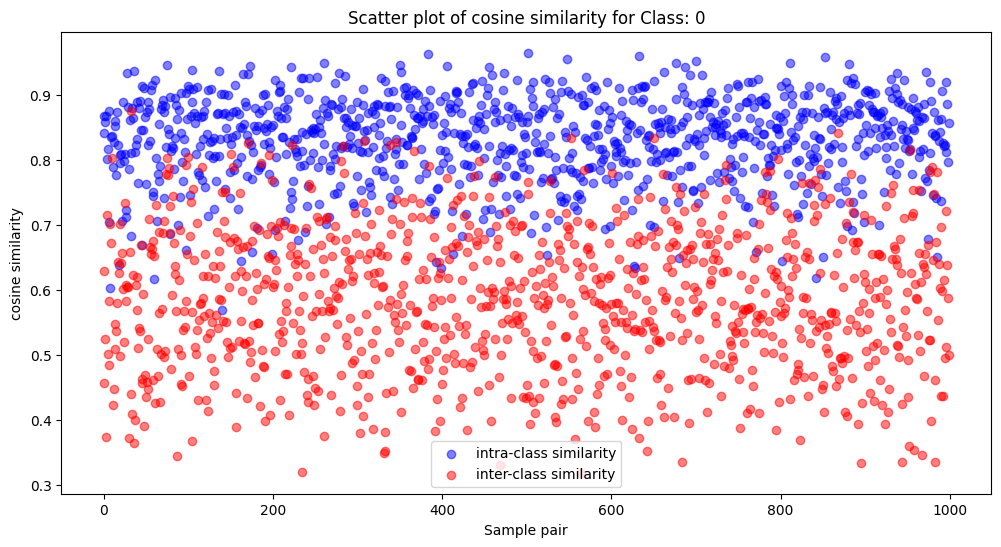

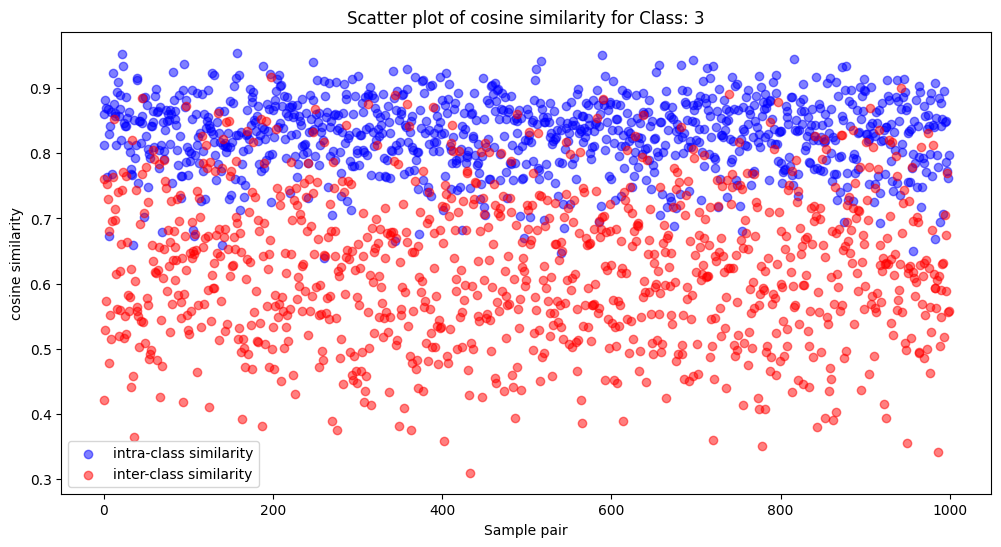

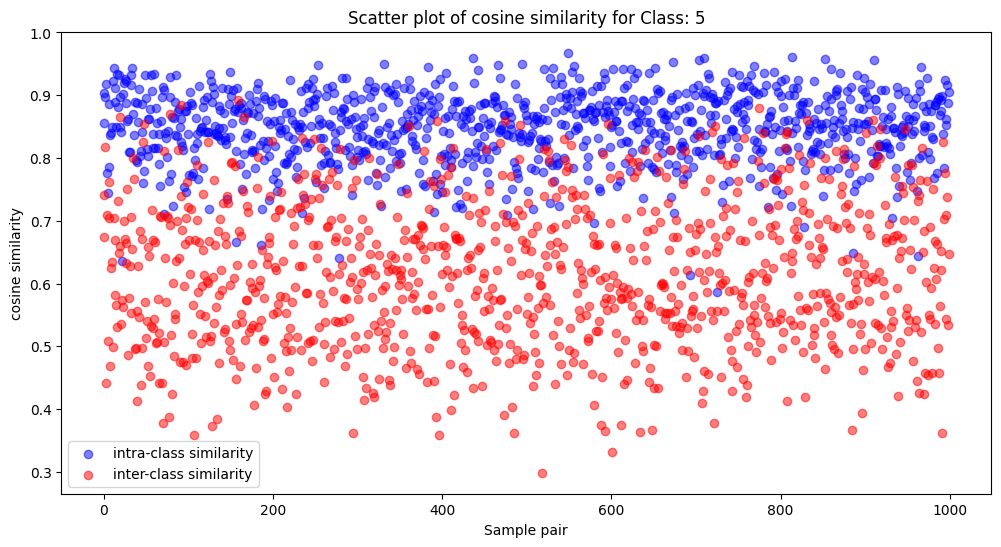

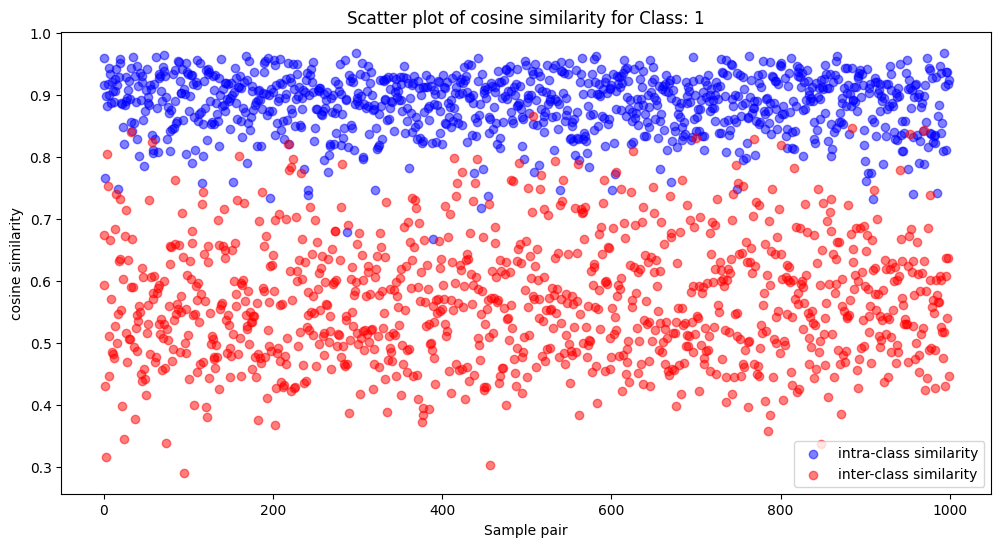

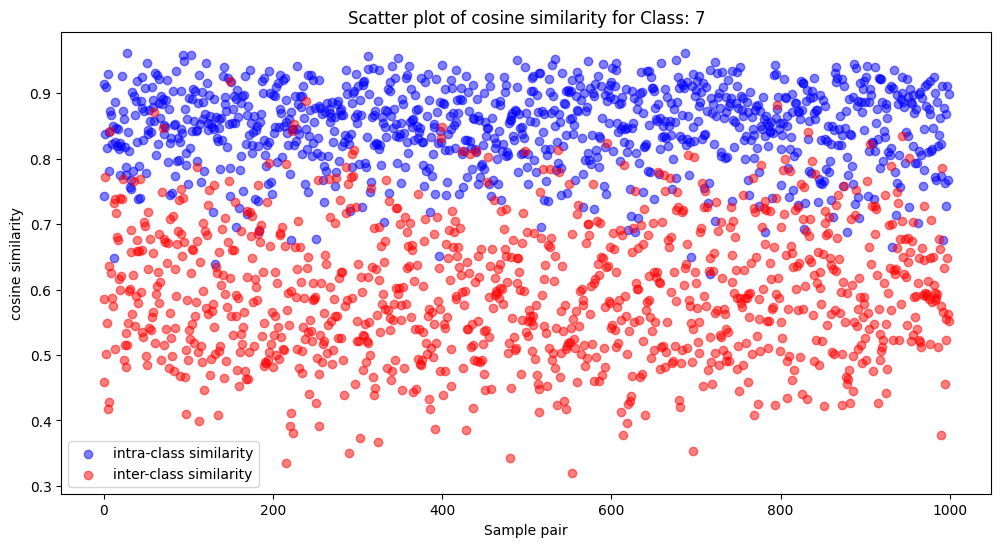

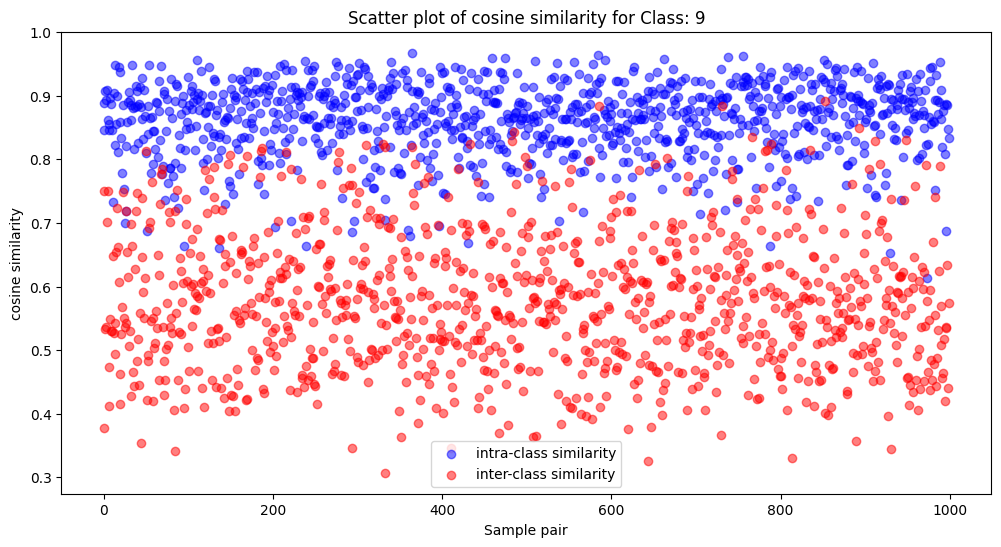

In [205]:
plot_scatter(cifar_cos_sim_matrix)


## DenseNet - Cifar10

In [206]:
from densenet import DenseNetCifar

In [207]:
dn_nclasses = 10
dn_scale = 32
dn_channels = 3
dn_cifar_num_epochs = 50
dn_model = DenseNetCifar(dn_nclasses, dn_scale, dn_channels, proto_layer=4,layer_norm = False, entry_stride = 1).to(device)


In [208]:
#train(dn_model, cifar_train_loader, cifar_optimizer, 'dn_cifar10', dn_cifar_num_epochs)